 TMA4320 Project 1 - Biophysics

# 0.0 Motivation
Biophysics is an interdisciplinary science that uses physics to study and explain numerous biological phenomenons. A common and relevant example of this is how scientists in this field conduct research concerned with understanding the physical interactions between the various systems of a cell. With the help of both classical and modern physics, one can get a better grasp of how structures inside the cells are formed and how they behave. In this project, we are going to study and simulate these phenomenons by using theories from electromagnetism.

Cells contain membrane-less organelles (also referred to as clusters), which are structures that - similar to organs in our body - performs various important tasks within the cells. These organelles can be described as liquid droplets formed by the spontaneous phase separation of some of the components present in the cells, and studies have shown that electrostatic interactions plays an important role in their formations. The organelles consist of charged molecules called monomers, which are bound together by covalent bonds. These connections of monomers are called polymers. In addition to moving around, polymers can also flex and rotate around their bonds. This allows them to change their shape to better interact with surfaces and other polymers.

In biology it is shown that we can, by switching on and off the charge of the biopolymer, control the rate of this organelle formation. We can use numerical methods to simulate an organelle formation, and study how things like temperature and monomer connectivity impacts these formations.

There are multiple ways to numerically simulate such a behavior, but we will use a type of Monte Carlo-algorithm called the Metropolis algorithm. This is a numerical method that uses random sampling, and in our case the randomness will determine the direction that our polymers will move in and in some part how often thermal fluctuations affect the system. More on how the Monte Carlo-algorithm works later.

To develop the necessary framework and functions, the project will begin by working with and simulating systems of monomers in a solvent. We will show how these bind together to form clusters in order to minimize the system's energy. Then we will turn our attention to polymers and how these connect to form organelles by moving and flexing.



## 0.1 Numerical groundwork
As this is a paper about modeling biological systems numerically, we are going to need some tools. Numpy is a useful library for scientific calculations written in C, this means that using numpy functions vastly reduces the runtime of our code. We will also be using the pyplot and IPython.display libraries for visualization purposes, and time to manage progress on large computations. Scipy is another library for scientific calculations, and later we will make use of the function `ndimage.label()`. The tempfile package gives us the ability to save arrays to files. This is especially useful for saving output of long calculations.

In [1]:
import numpy as np
from scipy.ndimage import label

import matplotlib.pyplot as plt
from IPython.display import display, Latex, Math

import time

from tempfile import TemporaryFile
plt.rcParams['figure.dpi'] = 250


In [2]:

# %%javascript
# MathJax.Hub.Config({
#     TeX: { equationNumbers: { autoNumber: "AMS" } }
# });

## 0.2 Physical groundwork
To simplify the work of modeling a physical system, we will do calculations and simulations using discrete values. However, as the end goal is to model actual physical properties and sizes, we are going to define some physical constants to incorporate our discrete models. 
The physical distance between adjacent grid points in our model will be defined as $a = 23\mu m$, which is about the size of a single monomer. Realistically we would like a smaller value for $a$, however this would dramatically increase computational runtime. 
Our environment is a liquid solution, so we will be using the relative permittivity of water at room temperature $\epsilon_r = 78$.

In [3]:
a = 23e-6
e_r = 78 

# 1.0 Modeling systems of monomers
In this paper we are going to simulate a system of interacting monomers in a solvent. This will be done by using a Monte Carlo algorithm (more specifically the Metropolis algorithm), which is a method using random sampling. 


## 1.1 The grid
To be able to run the simulation we first have to find a way to describe the monomer-system numerically. We do this by creating an NxN-grid with M positively charged and M negatively charged monomers placed at random positions throughout the grid. As the boundaries of the grid would affect the interactions of monomers, consequently inducing surface effects that would not present in a real solution. We will simulate an "infinite" grid, more precisely a periodic boundary condition. Motion out one side of the grid will continue out of the adjacent side.

The charge of the monomers is always equal to the elementary charge e. To describe this numerically we use that a positively charged monomer will have a value of $-1$. 

Even though this is the case, it will be useful later to be able to address and find specific monomers. A solution to this is to enumerate them. We give all positively charged monomers a unique positive number from $1$ to $M$, and similarly for the negative monomers by using negative numbers from -$1$ to $-M$. 

In this point we will define a function that generates a random system setup, describing a solvent containing monomers. We wish to specify the width of the grid, and the number of monomers that will be placed in the grid.

In [4]:
def generate_monomer_grid(N,M):
    '''NxN grid with M positive and M negative monomers. So 2*M non-empty slots in N x N grid'''
    assert (N*N > 2*M) #Making sure there is enough space on the grid

    grid = np.zeros((N,N))
    for i in range(M):
        randPos = (np.random.randint(0,N),np.random.randint(0,N))
        while not (grid[randPos] == 0):
            randPos = (np.random.randint(0,N),np.random.randint(0,N))
        grid[randPos] = i + 1
    for i in range(M):
        randPos = (np.random.randint(0,N),np.random.randint(0,N))
        while not (grid[randPos] == 0):
            randPos = (np.random.randint(0,N),np.random.randint(0,N))
        grid[randPos]= - (i + 1)
    return grid


## 1.2 Visualizing our system
In order to visualize the monomers in the solvent, we create a function that plots the system. Here we can choose to either plot the monomers with just charges 1 or -1, or plot them with their enumerated value (which will come in handy later).

In [5]:
def plot_grid(grid, plot_with_equal_charge = False, title = "Title", color_map = "coolwarm",figuretext = True):
    '''Plots NxN grid with M positive and M negative monomers as a colormesh.
    '''
    '''
    Plots NxN grid with M positive and M negative monomers as a colormesh.
    Input:
        grid: The grid that will be plotted.
        plot_with_equal_charge: Bool that decides if the monomers will be plotted as a collection of 1s and -1s or with their unique value.
    '''
    plt.rcParams['figure.figsize'] = [2, 2]

    grid_to_be_plotted = np.copy(grid)
    N = len(grid)
    M = int( np.max(grid) ) # Since the mononers/polymers are uniquely indexed from 1, the total is equal to the max
    L = int( len(np.argwhere(grid) / 2) / (2*M)  ) # Find the number of monomers in the grid

    if plot_with_equal_charge:
        for arr in grid_to_be_plotted:
            arr[arr > 0] = 1
            arr[arr < 0] = -1
    
    plt.pcolormesh(
        grid_to_be_plotted[::-1,], 
        cmap=color_map
        )
    plt.title(
        title, 
        fontsize = "large",
        fontweight = "bold"
        )
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    if figuretext:
        plt.figtext(
            x=0,
            y=0,
            s=f'M: {M}, L: {L}. Grid size: {N}x{N}',
            fontsize="x-small"

        )
        
    plt.show()

## 1.3 Interactions between monomers



In our coming simulation, we are interested in examining a given system's total energy. This energy is a result of the potential energy from electrostatic interactions between monomers. In our simulations, we will approximate the interactions between monomers to be zero unless they are situated directly beside each other in the grid. This implies that monomers located diagonally to each other do not interact. Although this approximation might seem crude, it can be justified by the solvent's ability to screen electric fields emitted from the monomers.

To examine the interactions between monomers, we will need a function that returns the coordinates of all the nearest neighbors to a given coordinate in the grid. This is where the implementation of the periodic boundary condition comes into play. A neat trick, given the discrete nature of our grid, is to use the periodic property of the modulus operator. Each axis in our grid can be represented as the group of integers under modulo $N$ adition: $\Z_N = \{0, 1, 2, ..., N-1\} $. It is worth mentioning that in python, the modulus of a negative integer is defined to have the same sign as the denominator (in our case, N). This ensures that we always stay within our grid using only the modulo operator.

In [6]:
def nearest_neighbors(X, pnt):
    '''
    Returns the coordinates of [i, j]'s nearest neighbours in X (over, left, under, right)
    Input:
        X: (N*N)-array describing the system
        pnt: [i, j]: (1*2)-array describing a point in X
            i: integer, the i'th position down the collumns of X
            j: integer, the j'th position accros the rows of X
    Output: an array of points given as (1*2)-arrays. These are the coordinates of the NN's
        [
        p_up:   [i, j], point over pnt
        p_left: [i, j], point left of pnt
        p_down: [i, j], point under pnt
        p_right:[i, j], point right of pnt
        ]
    
    '''
    # N is the width of the grid
    N = len(X)
    
    #pack out i and j from pnt
    i = pnt[0]
    j = pnt[1]
    
    #define the neighbouring points
    p_up    = [(i-1)%N,  j       ]  # Use the property of cyclic groups of integers under modulo addition 
    p_left  = [ i      , (j-1)%N ]  # to ensure that i stays within [0, 1, 2, ... , N-1] and that
    p_down  = [(i+1)%N,  j       ]            # j stays within [0, 1, ... , N-1].
    p_right = [ i      , (j+1)%N ]
    
    return [p_up, p_left, p_down, p_right] 
    

Generally we are only interested in the nearest neighbors that are monomers. Hence we will also define a function that returns the neighbors that are in fact monomers to a given point. This function utilizes the previously defined `nearest_neighbors()`.

In [7]:
def get_monomer_neighbors(X, m):
    '''
    This function takes in a grid and a monomer postion. Then it returns the positions of 
    neighboring monomers to the monomer m. If m doesnt have any monomer neighbors, the function
    returns an empty array.
    Input:
        X: n*n-array, describing the system
        m: coordinates of monomer to check
    Output:
        monomer_neighbors: an array containing the positions of m's neighbors, that also are monomers
        w_neighbors: an array containing the values in X of the corresponding neighbors
    '''
    # Define an array of all the NN's to the monomer m
    NN = np.array(nearest_neighbors(X, m)) 
    
    #for simplicity, pack out NN into two arrays containing the i positions and j positions of the NN's
    # this is done using numpy arrays
    # i.e. NN = [ [i_0, j_0],  [i_1, j_1], ... , [i_3, j_3]]
    #  ---> I = [i_0, i_1, ... , i_3]
    #  ---> J = [j_0, j_1, ... , j_3]
    I = NN[:, 0]
    J = NN[:, 1]
    
    # Define an array containing the values of m's neighbors
    w_neighbors = X[I, J]
    
    # Define an array contiaining the coordinates of all neighboring monomers
    mon_neighbor_index = np.flatnonzero(w_neighbors) #use flatnonzero, as argwhere is not recomended for indexing arrays
    monomer_neighbors = NN[mon_neighbor_index]
    return monomer_neighbors, w_neighbors
    

The potential energy between two (neighboring) monomers situated at $\textbf{r}_k$ and $\textbf{r}_l$ can be found using Coulombs law:

$$
V_{kl} = \omega_{k}\omega_{l}\frac{e^2}{4\pi\epsilon_{0}\epsilon_{r}a^2}\frac{a^2}{|\textbf{r}_k-\textbf{r}_l|} = \omega_{k}\omega_{l}\alpha\frac{a^2}{|\textbf{r}_k-\textbf{r}_l|}
$$

where $\omega_{k}$ and $\omega_{l}$ has the values $+1$ or $-1$ based the charge of the two monomers, $a$ is the distance between grid points, $|\textbf{r}_k-\textbf{r}_l|$  is the absolute value of the distance between the two monomers and $\alpha$ is a constants with units Joule.

Because of our approximation the absolute value of the distance between the two monomers is always the same, which means that the last part of the expression equals 1. The potential energy between two monomers can therefore be written as:
$$
    V_{kl} = \omega_{k}\omega_{l}\alpha
$$

If we take the sum of all the interactions of neighboring monomers, we are able to describe the system's total potential energy. However, we are evaluating every interaction twice by checking every monomer, so we must multiply by $1/2$.
The total system energy can then be described as the sum:

\begin{equation}
    E = \frac{1}{2}\sum_{M} V_M = \frac{1}{2}\sum_{M} \sum_{i=0}^{3} \omega_{M}\omega_{i}
\end{equation}


Where $\omega_M$ is the charge of monomer $M$, and $\omega_i$ is the charge of $M$'s $i^{th}$ neighbor. Throughout this paper we will be using the following convention of numerating directions:
$$
direction = \begin{cases}
    0 & up \\ 
    1 & left \\
    2 & down  \\
    3 & right
\end{cases}
$$

The following function calculates \@ref(eq:binom) for a given grid.

In [8]:
def total_system_energy(grid):
    '''
    Calculates the total enegry in a system. This is done by calculating the 
    binding-energy between all monomers.
    Input:
        grid: (m*n)-array of integers, the grid of the system. 
            0 denotes solvent, 
            +1 denotes positive monomers in the polymer 1,
            -1 denotes negative monomers in the polymer -1
    Output:
        E_total: float, the total enegry inside grid
            Unit [E/alpha], where alpha is a constant with unit Joule
    
    '''
    E_total = 0
    monomers = np.argwhere(grid) #[i,j]-coordinates of all the monomers in grid
    
    # iterate through all the monomers, m[0] is the i coordinate, m[1] is the j coordinate
    for m in monomers:

        # Define an array containing the values of m's neighbors
        w_neighbors = get_monomer_neighbors(grid, m)[1]
        
        # Define the value of the current monomer
        w = grid[ m[0], m[1] ]

        # The neighbors that have the same value as the current monomer will be 
        # changed to zero, in the array of neighbor values, as we are not going to calcule 
        # the energy within the polymers
        
        w_neighbors[np.argwhere( w_neighbors == w )] = 0
        
        
        # Add the energy of all the interactions between neighbors.
        # Note that we multiply by 0.5 because alle the interactions are summed twice X
        E_total += 0.5 * np.sum( np.sign(w_neighbors) * np.sign(w) ) 
        
    
    return E_total

## Testing our functions to this point
A useful practice is to make sure the functions behave. Using a small grid size and a manageable amount of monomers, we will test our functions to generate expected results. Here we have defined a function that will generate a random monomer system and plot it, then calculate the total energy of that system. This is done using the previously defined functions.

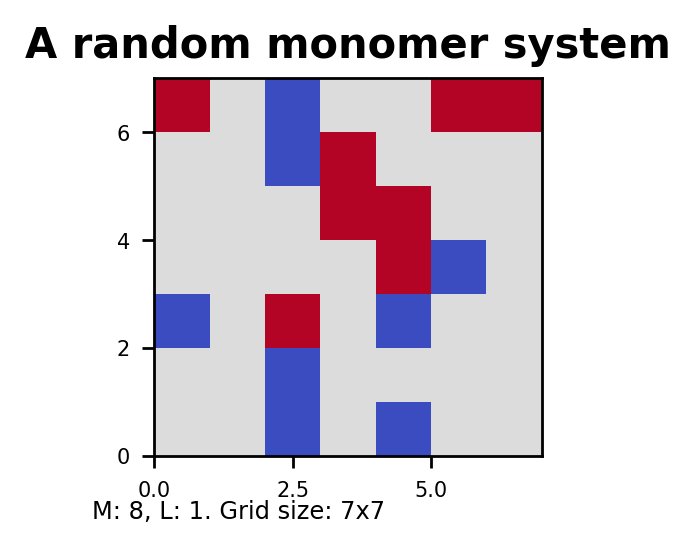

<IPython.core.display.Math object>

In [9]:
def test_energy():
    test_grid = generate_monomer_grid(7, 8)
    plot_grid(test_grid, True, title="A random monomer system")
    
    E = total_system_energy(test_grid)
    
    display(Math(fr'This system has a total energy of $E = {E} \frac{{e^2}}{{4 \pi \epsilon_0 \epsilon_r a}}$'))
test_energy()

## 1.4 The Monte Carlo algorithm
The Monte Carlo/Metropolis algorithm functions by moving a random monomer in a random (legal) direction. The algorithm then checks how the new placement impacts the total energy of the system. If the energy in this new position is lower than the previous, the algorithm holds on to this new configuration of the system and moves on. If the energy is higher however, it is possible that the system still preserves this new configuration depending on a slightly random event, caused by thermal fluctuations. We will first generate a random number $p$<a name="intervall">1</a>$\in [0, 1) $, then compare it to the quantity:
\begin{equation}
\tag{2}
    e ^ {−\beta(E_{new}-E_{old})}, \quad \beta = \frac{1}{\kappa_BT}
\end{equation}
If $p$ is smaller than (2), then the move is realized, even though the system's energy increases. By examining (2) we notice that a higher temperature will likely cause more energy-costly moves. T
his process of moving a monomer and deciding whether to keep the new configuration is what we will define as one Monte Calo step, denoted $t$.

<br></br>
<sup>[1](#intervall)</sup> In the metropolis algorithm $p$ is defined in the fully open interval. We will however use the half-open interval, as this is less computationally demanding.


In order to implement the Monte-Carlo algorithm, we will need some utility functions. The first one is `legal_monomer_move()`, which is a simple bool function that checks if move is legal. Given a grid, the unique value of the polymer in question, and a direction, where direction is a number from $0$ to $3$ as described above.

In [10]:
def legal_monomer_move(grid, val, direction):
    '''
    Checks if a move is illegal. This will be the case if a move is trying to move a monomer on top of another monomer.
    
    Input:
        gird: Current grid.
        val: The unique value of monomer in grid.
        direction: The direction that the monomer will be moved in given as an integer. 
            up = 0
            left = 1
            down = 2
            right = 3
    Output:
        bool: True if the move is legal and False if the move is illegal.
    '''
    pos = np.argwhere(grid==val)[0]
    
    neighbors_pos_arr = nearest_neighbors(grid, pos) # 2d-array with the coordinates of the monomers neighbors 
    
    new_pos = neighbors_pos_arr[direction] # The coordinates of the position where the monomer will be moved to.
    new_pos_val = grid[new_pos[0]][new_pos[1]] # The value in the new position.
    
    if new_pos_val != 0.0: # Returns false if there is a monomer in the new posision.
        return False
    return True

The second utility function is `move_monomer()`, which moves a certain monomer, in a given grid, in a given direction.

In [11]:
def move_monomer(grid, val, direction):
    '''
    Moves monomer in a given direction from its current posistion 
    
    Input:
        gird: Current grid.
        val: The unique value of monomer in grid.
        direction: The direction that the monomer will be moved in given as an integer. 
            up = 0
            left = 1
            down = 2
            right = 3
    Output:
        new_grid: The (new) grid where the polymer has been moved from its old position.
    '''
    
    pos = np.argwhere(grid==val)[0] # The coordinates of the monomer

    neighbors_pos_arr = nearest_neighbors(grid, pos) # 2d-array with the coordinates of the monomers neighbors 

    new_pos = neighbors_pos_arr[direction] # The coordinates of the position where the monomer will be moved to.
    new_val = grid[new_pos[0]][new_pos[1]] # The value in the position where the monomer will be moved to.
    
    # Creating a new grid, and then exchanging the values of where the monomer currently is and where it is beeing moved.
    new_grid = np.copy(grid)
    new_grid[pos[0]][pos[1]] = new_val
    new_grid[new_pos[0]][new_pos[1]] = val

    return new_grid

We implemented the Monte Carlo algorithm based on a distributed pseudo-code, but for our purposes we made some minor alterations. The original algorithm used the parameter `N` as an input, and then generated the grid inside the function. We implemented it so the grid is generated elsewhere, then used as an input parameter in the function.

During this project, the Monte Carlo algorithm will be used on monomers, and polymers with two different movement mechanisms. The implementation will be slightly different for each of these, so we created three different versions, distinguished by the string variable `“option”`. This increases the amount of code, but not the runtime, and it’s a fairly readable and clear implementation for the reader compared to making three different functions.


Another minor alteration is that we made an option to show the progress every `x` steps, with `x = 10 000` steps by default. 

In [12]:
def monte_carlo(N_s_input, T, grid, option, progress_update_steps = 10000):
    '''
    Monte Carlo simulation of interaction polymers and their energy.
    
    Input:
        N_s_input: The number of Monte Carlo steps in the simulation.
        T: Temperature in Kelvin.
        grid: The initial system configuration before the simulation starts.
        option: A string describing what simulation we  wish to use.
            "monomer": Runs a monomer simulation
            "poly-rigid": Runs a polymer simulation using rigid move
            "poly-flex": Runs a polymer simulation using flex move
        progress_update_steps: How often the simulation will output updates for how far it has come. Set to -1 for no updates. 
        return_30K_grid: Boolean. If True the algorithm will return the grid configuration after 30K steps.
    Output:
        returned_grid: The system configuration after the simulation.
        (grid_30K: The grid configuration after 30K steps.)
        e: The energies of the system for each iteration in the for-loop.
    '''
    
    ##################################################################################################################

    #                       Intital Monte Carlo setup
    
    # This is to make absolutley shure that editing the grid does not go back in time
    returned_grid = np.copy(grid)
    
    
    if progress_update_steps != -1:
        start_time = time.time() # Starttime of function.
        print("Starting Monte Carlo simulation:")
    
    # The constant beta
    k_B = 1.38e-23
    beta = 1/(T*k_B) # Constant used in the for-loop
    
    # Will be used for the constant alpha
    e_0 = 8.845e-12
    e_charge = 1.6e-19
    e_r = 78 # relative permittivity
    
    E = total_system_energy(np.copy(returned_grid)) # Total energy in the current grid
    
    # Creating array with zeroes that will be filled with energy values, and setting the first value to be the current energy-value
    e = np.zeros(N_s_input)
    e[0] = E
    
    ##################################################################################################################

    #                       The differnt Monte Carlo loops


    if option == "monomer":
        
        # In the monomer simulation we will use a = 23 um
        a = 23e-6
        alpha = (e_charge**2)/(4*np.pi*e_r*e_0*(a**2))
        

        # For-loop that runs N_s times
        for i in range(N_s_input):
            # This initial part of the loop will be similar to the other loops.
            # However, the move functions and legal-move functions differ.

            
            # Equate the total energy of the current grid, and choose a random 
            # direction.
            E = total_system_energy(np.copy(returned_grid))             
            random_direction = np.random.randint(low=0, high=4)


            # First locate all the monomers, then pick a random monomer and
            # note its value.
            monomers = np.argwhere(returned_grid)
            p_pos = monomers[np.random.randint(0, len(monomers))]
            p_val = returned_grid[ p_pos[0], p_pos[1] ]

            
            # if-statement that runs if the move is legal        
            if legal_monomer_move(np.copy(returned_grid), p_val, random_direction): 
                
                # Move the polymer to its new (legal) position, and calculate the energy of the new grid
                new_grid = np.copy(move_monomer(np.copy(returned_grid), p_val, random_direction)) 
                E_new = total_system_energy(np.copy(new_grid))
                
                # These are the Monte Carlo choises, desribed in the above text.
                if E_new < E:
                    returned_grid = np.copy(new_grid) # Setting the grid equals to the new grid
                    E = E_new # Replacing the old energy with the new

                elif np.random.random() < np.exp(-beta*alpha*(E_new - E)):           
                    returned_grid = np.copy(new_grid) # Setting the grid equals to the new grid
                    E = E_new # Replacing the old energy with the new

            e[i] = E # Adds the energy of this current iteration to the array of energy-values

            if (i % progress_update_steps == 0 and i != 0 and progress_update_steps != -1):
                print(f"- PROGRESS: Step {i}, {100*i/N_s_input:.2f}%")

        if progress_update_steps != -1:
            print(f"Runtime: {(time.time() - start_time):.2f}s seconds.") # Prints the runtime of the function
        
        return returned_grid, e
    

    #   Polymer ridig move

    if option == "poly-rigid":
        # In the polymer simulation we will use a = 91 um
        a = 91e-6
        alpha = (e_charge**2)/(4*np.pi*e_r*e_0*(a**2))
        

        # For-loop that runs N_s times
        for i in range(N_s_input):
            # This initial part of the loop will be similar to the other loops.
            # However, the move functions and legal-move functions differ.
            
            # Equate the total energy of the current grid, and choose a random 
            # direction.
            E = total_system_energy(np.copy(returned_grid))             
            random_direction = np.random.randint(low=0, high=4)

            # First locate all the polymer, then pick a random polymer and
            # note its value.
            polymers = np.argwhere(returned_grid)
            p_pos = polymers[np.random.randint(0, len(polymers))]
            p_val = returned_grid[ p_pos[0], p_pos[1] ]

            # if-statement that runs if the move is legal        
            if legal_rigid_move(np.copy(returned_grid), p_val, random_direction): 
                
                # Move the polymer to its new (legal) position, and calculate the energy of the new grid
                new_grid = np.copy(rigid_move(np.copy(returned_grid), p_val, random_direction)) 
                E_new = total_system_energy(np.copy(new_grid))
                
                 # These are the Monte Carlo choises, desribed in the above text.
                if E_new < E:
                    returned_grid = np.copy(new_grid) # Setting the grid equals to the new grid
                    E = E_new # Replacing the old energy with the new

                elif np.random.random() < np.exp(-beta*alpha*(E_new - E)):           
                    returned_grid = np.copy(new_grid) # Setting the grid equals to the new grid
                    E = E_new # Replacing the old energy with the new
            
            e[i] = E # Adds the energy of this current iteration to the array of energy-values
            
            
            if i == 30000:
                grid_30K = np.copy(returned_grid)

            if (i % progress_update_steps == 0 and i != 0 and progress_update_steps != -1):
                print(f"- PROGRESS: Step {i}, {100*i/N_s_input:.2f}%")
        
        if progress_update_steps != -1:
            print(f"Runtime: {(time.time() - start_time):.2f}s seconds.") # Prints the runtime of the function

        return returned_grid, grid_30K, e
    

    #   Polymer Medium-flex move

    if option == "poly-flex":
        # In the polymer simulation we will use a = 91 um
        a = 91e-6
        alpha = (e_charge**2)/(4*np.pi*e_r*e_0*(a**2))
        
        grids = []

        # For-loop that runs N_s times
        for i in range(N_s_input):
            # This initial part of the loop will be similar to the other loops.
            # However, the move functions and legal-move functions differ.
            
            # Equate the total energy of the current grid, and choose a random 
            # direction.
            E = total_system_energy(np.copy(returned_grid))             
            random_direction = np.random.randint(low=0, high=4)

            # First locate all the polymer, then pick a random polymer and
            # note its value.
            polymers = np.argwhere(returned_grid)
            p_pos = polymers[np.random.randint(0, len(polymers))]
            p_val = returned_grid[ p_pos[0], p_pos[1] ]
            
            
            # new_grid = np.copy(flex_move(np.copy(returned_grid), p_val, random_direction))# Moving the polymer
            new_grid = np.copy(flex_move_slice_method(np.copy(returned_grid), p_val, random_direction))
        
            # if-statement that runs if the move is legal        
            if not broken_polymer(np.copy(new_grid), p_val): 
                # plot_grid(new_grid)
                
                grids.append(np.copy(new_grid))
                
                E_new = total_system_energy(np.copy(new_grid)) # Equating the total energy of the new grid
                if E_new < E:
                    returned_grid = np.copy(new_grid) # Setting the grid equals to the new grid
                    E = E_new # Setting the energy equals to the new energy
        
                elif np.random.random() < np.exp(-beta*alpha*(E_new - E)):                
                    returned_grid = np.copy(new_grid) # Setting the grid equals to the new grid
                    E = E_new # Setting the energy equals to the new energy
            
            e[i] = E # Adds the energy of this current iteration to the array of energy-values
            
            
            if (i % progress_update_steps == 0 and i != 0 and progress_update_steps != -1):
                print(f"- PROGRESS: Step {i}, {100*i/N_s_input:.2f}%")
    
        if progress_update_steps != -1:
            print(f"Runtime: {(time.time() - start_time):.2f}s seconds.") # Prints the runtime of the function
        
        return grids, returned_grid, e


### 1.4.1 Simulating a grid of monomers

Now we are ready to run our first simulation. Using the previously defined Monte Carlo function, with the monomer option. We are interested in observing the outcome of two equal setup grids, but at two different temperatures, $T = 200K$ and $T = 500$. Although these temperature variations are not realistic, we are curious to see the effect on the biological system.

In [13]:
def monomer_simulation():
    
    # Define the conditions of our simulation
    N_s = 50000
    N = 15
    M = 25
    T_low = 200
    T_high = 500
    

    initial_grid = generate_monomer_grid(N, M)

    # Run the simulation at different temperatures and save the outputs
    outgrid_200, energies_200 = monte_carlo(N_s, T_low, np.copy(initial_grid), "monomer", 5000)
    outgrid_500, energies_500 = monte_carlo(N_s, T_high, np.copy(initial_grid), "monomer", 5000)

    np.savez(
        'testrun_monte_carlo', 
        initial_grid = initial_grid,
        outgrid_200 = outgrid_200, 
        outgrid_500 = outgrid_500, 
        energies_200 = energies_200, 
        energies_500 = energies_500
        )

# monomer_simulation()

### 1.4.2 Presenting the results
To view the energy output of a simulation we will first need to define a new plotting function.

In [14]:
def plot_energies(N_s, e_arr, T_arr, titles = []):
    '''
    Function that shows how the energy develops as a function of t for both simulations in the same figure.
    
    Input:
        N_s: The number of Monte Carlo steps in the simulation.
        a_arr: 2D-arr containing one or multiple energy-arrays from the simulations.
        T_arr: 2D-arr containing one or multiple Temperatures from the simulations.
    '''
    plt.rcParams['figure.figsize'] = [10, 5]
    
    t = np.arange(0, N_s, 1) # Array with timesteps
    
    for i in range(len(e_arr)):
        if titles != []:
            plt.plot(t, e_arr[i], label = f"{titles[i]}, T = {T_arr[i]}K") # Plot for first simulation
        else:
            plt.plot(t, e_arr[i], label = f"T = {T_arr[i]}K") # Plot for first simulation
    
    # Add title and labelnames
    plt.title("Energy Plot", size = 15, weight="bold") 
    plt.xlabel(r"$t$", size = 15)
    plt.ylabel(r"$\frac{E}{\alpha}$", size = 20, rotation=0)
    
    # Showing the plot
    plt.legend()
    plt.show()  

The output of our simulation is saved to the file `'testrun_monte_carlo'`. Using our new, and old plotting function we are able to view the outcome of the previously run simulation.

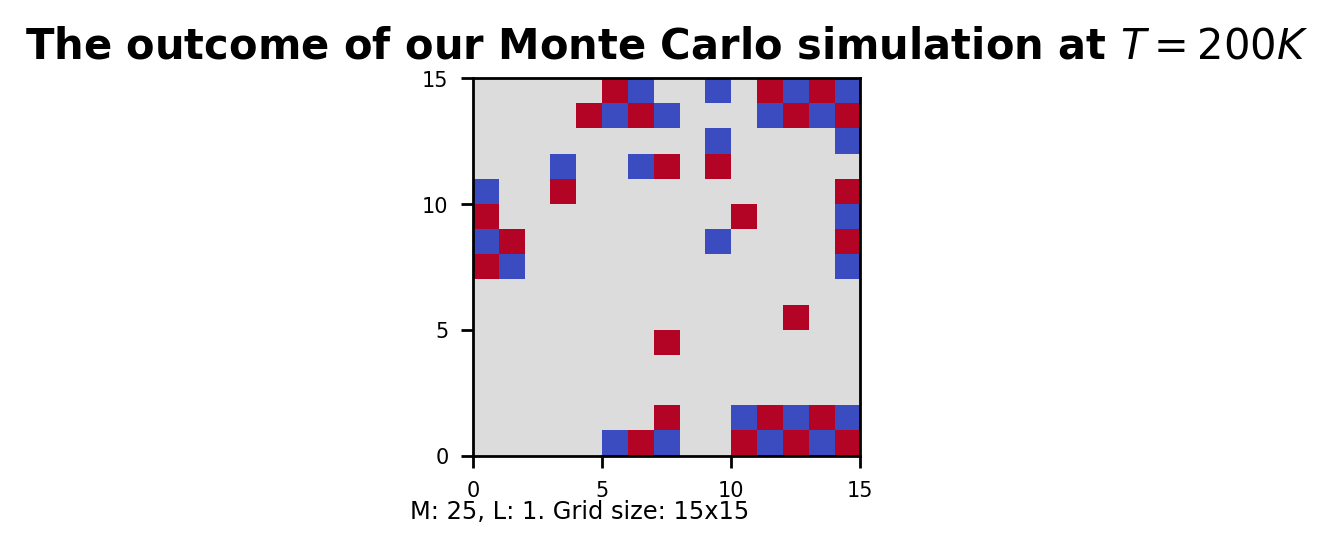

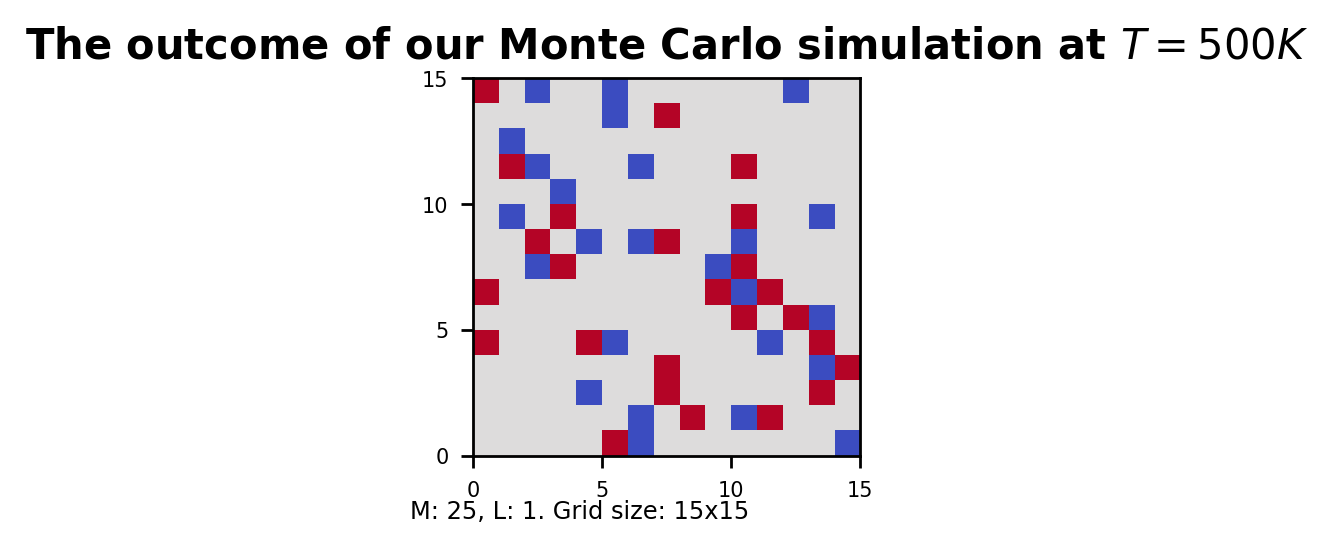

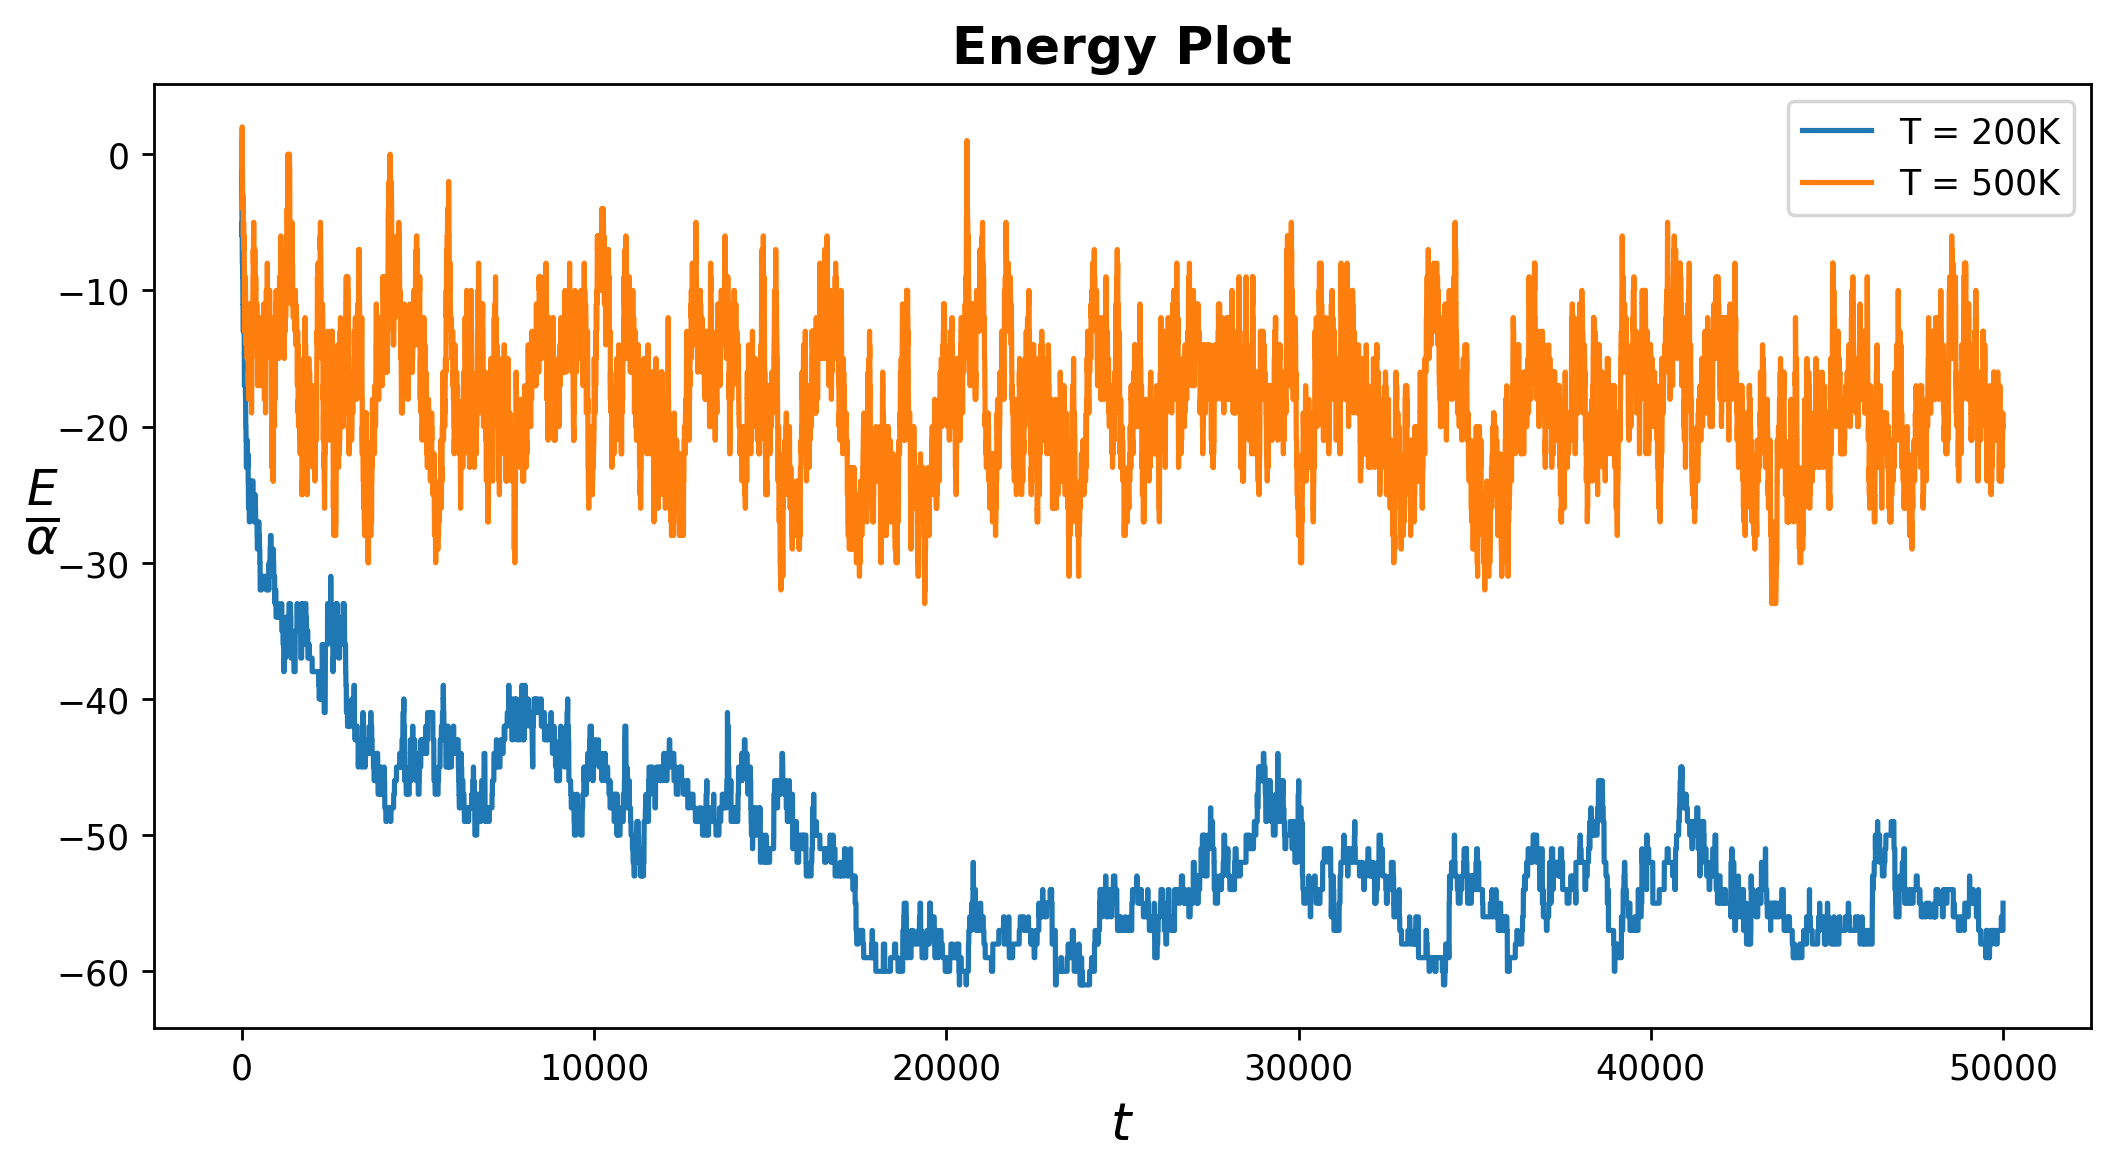

In [15]:
def plot_monomer_simulation():
    # Unpack the relevant data  from the saved file
    simulation_data = np.load('testrun_monte_carlo.npz')
    outgrid_200, energies_200 = simulation_data['outgrid_200'], simulation_data['energies_200']
    outgrid_500, energies_500 = simulation_data['outgrid_500'], simulation_data['energies_500']

    # Plotting for T=200K
    plot_grid(outgrid_200, True, "The outcome of our Monte Carlo simulation at $T=200K$")


    # Plotting for T=500K
    plot_grid(outgrid_500, True, "The outcome of our Monte Carlo simulation at $T=500K$")
    plot_energies(len(energies_500), [energies_200, energies_500], [200, 500])


plot_monomer_simulation()

In this particular run, $t_{equil}$ is reahed at around $30 000$ for $200K$, and around $5000$ for $500K$. 

From a physics standpoint, the value is different because the higher temperature leads to stronger random thermal fluctuations. Every physical system (with a non-zero temperature) will not remain in its equilibrium microscopic state. Instead, it will randomly sample all of its possible states, with probabilities given by the Boltzmann distribution - this is what we call thermal fluctuations. For example, we can see the effect in our plot that even though the energy has stopped falling and remains at a relatively stable value, it sporadically moves slightly up and down around the mean value. 

At a higher temperature, because of all the fluctuations, there is also less likely for the system to temporarily settle in local energy minima. This means that the initial conditions of the grid have less of an effect on the settling of the energy, and therefore it takes less time to reach equilibrium.   

In the code, this thermal fluctuations comes from a higher $T$, which leads to lower $\beta$. This leads to a smaller negative term in the exponent $e^{-\beta\alpha(E_{new}-E)}$, which in turn leads to a larger number, and therefore there is a greater chance of the random grid to be chosen in the Monte Carlo algorithm. So with a higher degree of randomness, there are not as many steps needed in order to reach the equilibrium.

## 1.7 Finding clusters

Monomers tend to form into clusters, which is defined as a group of monomers where there exists a continuous path between any pair of monomers belonging to the group. The path can also only be piecewise horizontal or vertical, and can only be along other monomers belonging to the same group.

To make it easier to work with clusters, it's a good idea to create a grid that in a better way describes a cluster of monomers as a single unit instead of describing every single monomer that the cluster is made up of. This is done by giving all the monomers in a cluster the same value. In a similar way to how we earlier enumerated the monomers, we also enumerate the clusters. Every cluster will be represented with an unique positive integer, and all of the monomers that this cluster consists of will have this integer as their value in the grid.

In order to transition between monomer-grids and cluster-grids, we create a function `cluster_grid(X)` which does this convertion for us.

In [16]:
def cluster_grid(X):
    '''
    This function takes in a grid describing a system om monomers, and outputs a new grid with the same
    system, however, the clusters are joined.
    Input:
        X: n*n-array, the current system of monomers
    Output:
        X: n*n-array, new grid with clusters
    '''
    monomers = tuple(map(tuple, np.argwhere(X))) #[i,j]-coordinates of all the monomers in X as tuplesaa
    current_monomer = monomers[0] #the current_monomer variable needs to be a tuple
    monomer_number = 1  #this discribes the current cluster that the algorythm is working on
    X[current_monomer] = monomer_number
    
    # Create arrays that will be utilized by the algorythm, with the first monomer as the initial element
    current_cluster = np.array([current_monomer], dtype='int')
    explored_path = np.array([current_monomer], dtype='int') 
    #print(f'Current cluster: \n{current_cluster}')

    
    monomer_neighbors = get_monomer_neighbors(X, current_monomer)[0]
    current_cluster = np.append(current_cluster, monomer_neighbors, axis=0)
    
    
    #print(f'Monomers: \n {monomers}')
    #print(f'0, 1, 5 is in monomers: \n{np.isin(monomers, [monomers[0], monomers[1], monomers[5]])}')
    #print(np.where([monomers[0], monomers[1], monomers[5]] in monomers))
    
    
    iteration = 0
    while ((len( np.unique(explored_path, axis=0 ) ) != len( np.unique(monomers, axis=0 ) ))):
        #if iteration%100 == 0: 
        #    print(iteration)
        #elif iteration%1 == 0:
        #    plot_grid(X)
        #    time.sleep(1)
        if iteration >= 1000:
            print("max iter")
            return X
        
        # Iterate through the monomers in current cluster to find the first element that has not
        # been explored
        #print(f'Current cluster: \n{current_cluster}\n\n')
        
        for i in range(len(current_cluster)):
            #print(f"current_cluster[i]: {current_cluster[i]}, ")
            #print(f"explored path: \n{explored_path}\n")
            m = tuple(current_cluster[i])
            
            explored_set = tuple(map(tuple, explored_path))  #need the array to be a tuple
            #print(f"current_cluster[i] in explored_path: {tuple(current_cluster[i]) in explored_set}\n\n")
            #print(f'i: {i}, len: {len(current_cluster)-1}')
            if not (m in explored_set):
                #print(f"X: {}")
                X[m] = monomer_number
                current_monomer = m
                explored_path = np.append( explored_path, [current_monomer], axis=0)
                break
            elif i == len(current_cluster)-1: #current_cluster[i][0] == current_cluster[-1][0] and current_cluster[i][1] == current_cluster[-1][0]:
                #print("\n\nNY MONIMER")
                monomer_number += 1
                #print(f'All the monomers: \n{monomers}\nAll the current explored path: \n{explored_set}\n\n')
                
                # Use sets to find the monomers that have not yet been explored
                monomer_set = set(monomers)
                explored_path_set = set( tuple(map(tuple, explored_path)) )
                not_explored = tuple(map(tuple, monomer_set.difference(explored_path_set)))
                
                current_monomer = not_explored[0]
                explored_path = np.unique( np.append( explored_path, [current_monomer], axis=0 ), axis=0 )
                X[current_monomer] = monomer_number 
                
                
        monomer_neighbors = get_monomer_neighbors(X, current_monomer)[0]
        current_cluster = np.unique( np.append(current_cluster, monomer_neighbors, axis=0), axis=0 )
        iteration += 1
    return X

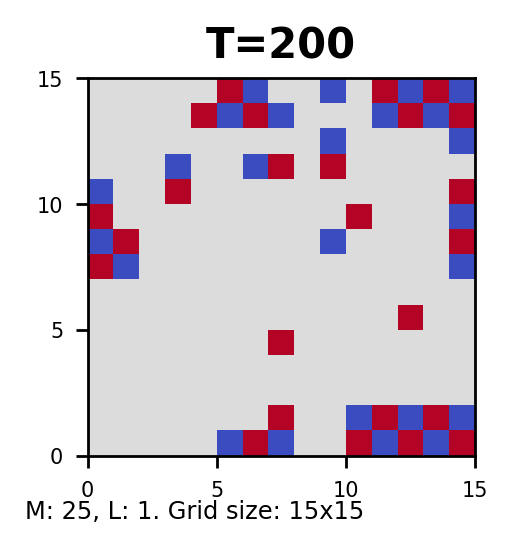

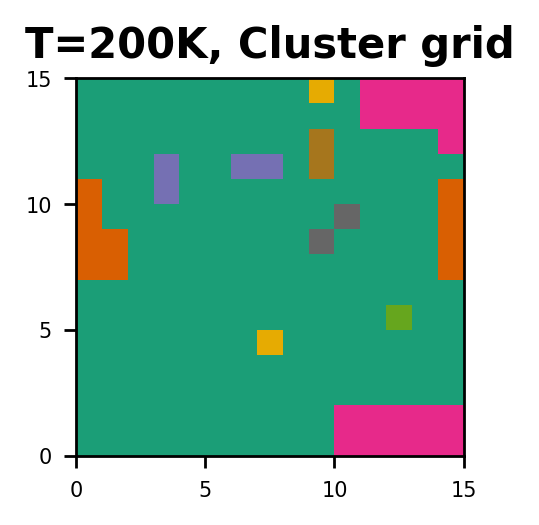

In [17]:
def plot_cluster_grid():
    simulation_data = np.load('testrun_monte_carlo.npz')
    outgrid_200 = simulation_data['outgrid_200']
    plot_grid(outgrid_200, title="T=200", plot_with_equal_charge=True)
    
    cluster_grid_outgrid = cluster_grid(np.copy(outgrid_200))
    plot_grid(cluster_grid_outgrid,title="T=200K, Cluster grid", color_map="Dark2",figuretext=False)

plot_cluster_grid()

## 1.7 Mean Cluster Size

When we described how the Monte Carlo-algorithm worked, we introduced the system property and gave a formula for how we can calculate its mean value. Now, we will use this to observe the cluster size, denoted as $d$, and find its mean value $\langle d\rangle$ as a funciton of the temperature $T$. 

### 1.7.1 Estimation of steps until equilibrium
It will take some time before the system finds itself in a state that is representative for the system’s natural state. This means that we have to wait to wait for a certain amount of steps before we can start to measure cluster sizes. The numbers of steps needed for a system to reach its equilibrium, $t_{equil}$, can be estimated using the formula
$$
t_{equil} = t_{max}exp(-s(T-T_{l})) + C
$$

where $T$ is the temperature of the system, $T_{l} = 100K$, $t_{max} = 100000$, $s = \frac{1}{200}$ and $C = 10000$.

In [18]:
def t_equilibrium(T):
    '''
    Function that, for a given temperature, equates the number of Monte Carlo-steps neccecary for a system to reach equilibrium.
    Input:
        T: Temperature of the system in kelvin.
    Output:
        t_equil: Number of steps needed to reach equilibrium.
    '''
    t_max = 100000
    s = 1/200
    C = 10000
    T_l = 100
    return t_max*np.exp(-s*(T-T_l)) + C

### 1.7.2 Mean cluster size of single grid
We can easily find the mean cluster size of a single grid by summing the size of each cluster, and then dividing by the number of clusters.

In [19]:
def mean_cluster_size_constant_T(grid):
    '''
    Function that equates the mean cluster size of a grid.
    Input:
        grid: NxN grid for which we will equate the mean cluster size.
    Output:
        The mean cluster size of the grid.
    '''
    mean_cluster_sizes = []
    grid_cluster = cluster_grid(np.copy(grid))
    indexes = np.nonzero(grid_cluster)
        
    for i in np.unique(grid_cluster[indexes]):
        mean_cluster_sizes.append((grid_cluster[indexes]==i).sum())
   
    return np.average(mean_cluster_sizes)

### 1.7.3 Mean cluster size as function of T

The mean cluster size will be calculated for ten evenly spaced temperatures between $T_{l} = 100K$ and $T_{h} = 1 \ 000K$. For every temperature it will be taken $n$ measurements with $t_{r} = 1 \ 000$ additional Monte Carlo between each one. This means that we will first let the system reach equilibrium, then let the Monte Carlo algorithm run 1000 more steps and equate the mean cluster size of the updated grid, and then repeat this last procedure $n$ times. Finally, we calculate the average value of the $n$ mean cluster size values. This is done for all of the ten temperatures.
Even though it takes some time, we need to make $n$ measurements instead of just one to avoid that any fluctuations of the cluster size impacts our results. The larger $n$ is, the more accurate will our mean cluster size be, but it will also increase the runtime of our function. F.ex. if we use $n = 50$, we would have to calculate $40 \ 000$ more Monte Carlo steps than if we would have used $n = 10$ (when $t_{r} = 1000$)
 
The following function `mean_cluster_sizes()` calculates the mean cluster sizes for an array of T-values by running the procedure described above.

In [20]:
def mean_cluster_sizes(N, M, n, temps):
    '''
    Function that equates the mean cluster size for an array of different T values
    Input:
        N: The size of the grid.
        M: The number of monomers.
        n: The number of measurements of the cluster size for each temperature
        temps: Array of temperatures given in Kelvin.
    Output:
        mean_cluster_sizes: Array with the mean cluster sizes for the different temperatures.
        mean_cluster_deviations: Standard deviation of mean cluster size
    '''
    t_r = 1000 # The number of steps between each measurement.
    
    mean_cluster_sizes = np.zeros(len(temps)) # Creating empty array that will be filled with the mean cluster sizes.
    mean_cluster_deviations = np.zeros(len(temps))
    
    # Iterates through the temperatures in temps.
    for i, T_temp in enumerate(temps):
        grid_0 = generate_monomer_grid(N,M) # Creating a new initial grid for every temperature.
        t_equil = int(t_equilibrium(T_temp)) # Calculating how many steps are needed for the system to reach equilibrium.
        
        # Running the monte carlo algorithm for the amount of steps needed for the system to reach equilibrium.
        temp_grid_0, e_temp = monte_carlo(t_equil, T_temp, np.copy(grid_0), "monomer", progress_update_steps = -1)
        # We are going to take n measurements for the mean cluster size, and then take the average of these values. 
        mean_cluster_sizes_constant_T = np.zeros(n)
        
        # Loop that runs the monte carlo algorithm n times, with t_r steps for each time. 
        # After every monte carlo, temp_grid_0 gets updated to become to grid that the algorithm returned, 
        for j in range(0, n):
            temp_grid, e_temp = monte_carlo(t_r, T_temp, np.copy(temp_grid_0), "monomer", progress_update_steps = -1)
            mean_cluster_sizes_constant_T[j] = mean_cluster_size_constant_T(np.copy(temp_grid)) # Calculating the mean cluster size for the grid that the monte carlo algorithm returned.
            temp_grid_0 = np.copy(temp_grid)

        # Equating the average mean cluster size for this temperature.
        mean_cluster_sizes[i] = np.average(mean_cluster_sizes_constant_T) 
        mean_cluster_deviations[i]=np.std(mean_cluster_sizes_constant_T)
    return mean_cluster_sizes, mean_cluster_deviations

### 1.7.4 Presenting the results

In [21]:
def calculate_mean_cluster_size():
    N = 15
    M = 25
    L = 1
    n = 10
    
    # Creating the temperature array.
    T_l = 100
    T_h = 1000
    number_of_temps = 10
    temps = np.linspace(T_l, T_h, number_of_temps)
    
    # Calculating the mean cluster sizes
    mean_cluster_sizes_arr, mean_stddev_arr  = mean_cluster_sizes(N, M, n, temps)
    
    np.savez(
        'mean_cluster_sizes', 
        temps = temps,
        mean_cluster_sizes = mean_cluster_sizes_arr,
        mean_stddev_arr = mean_stddev_arr
        )
    
#calculate_mean_cluster_size()  

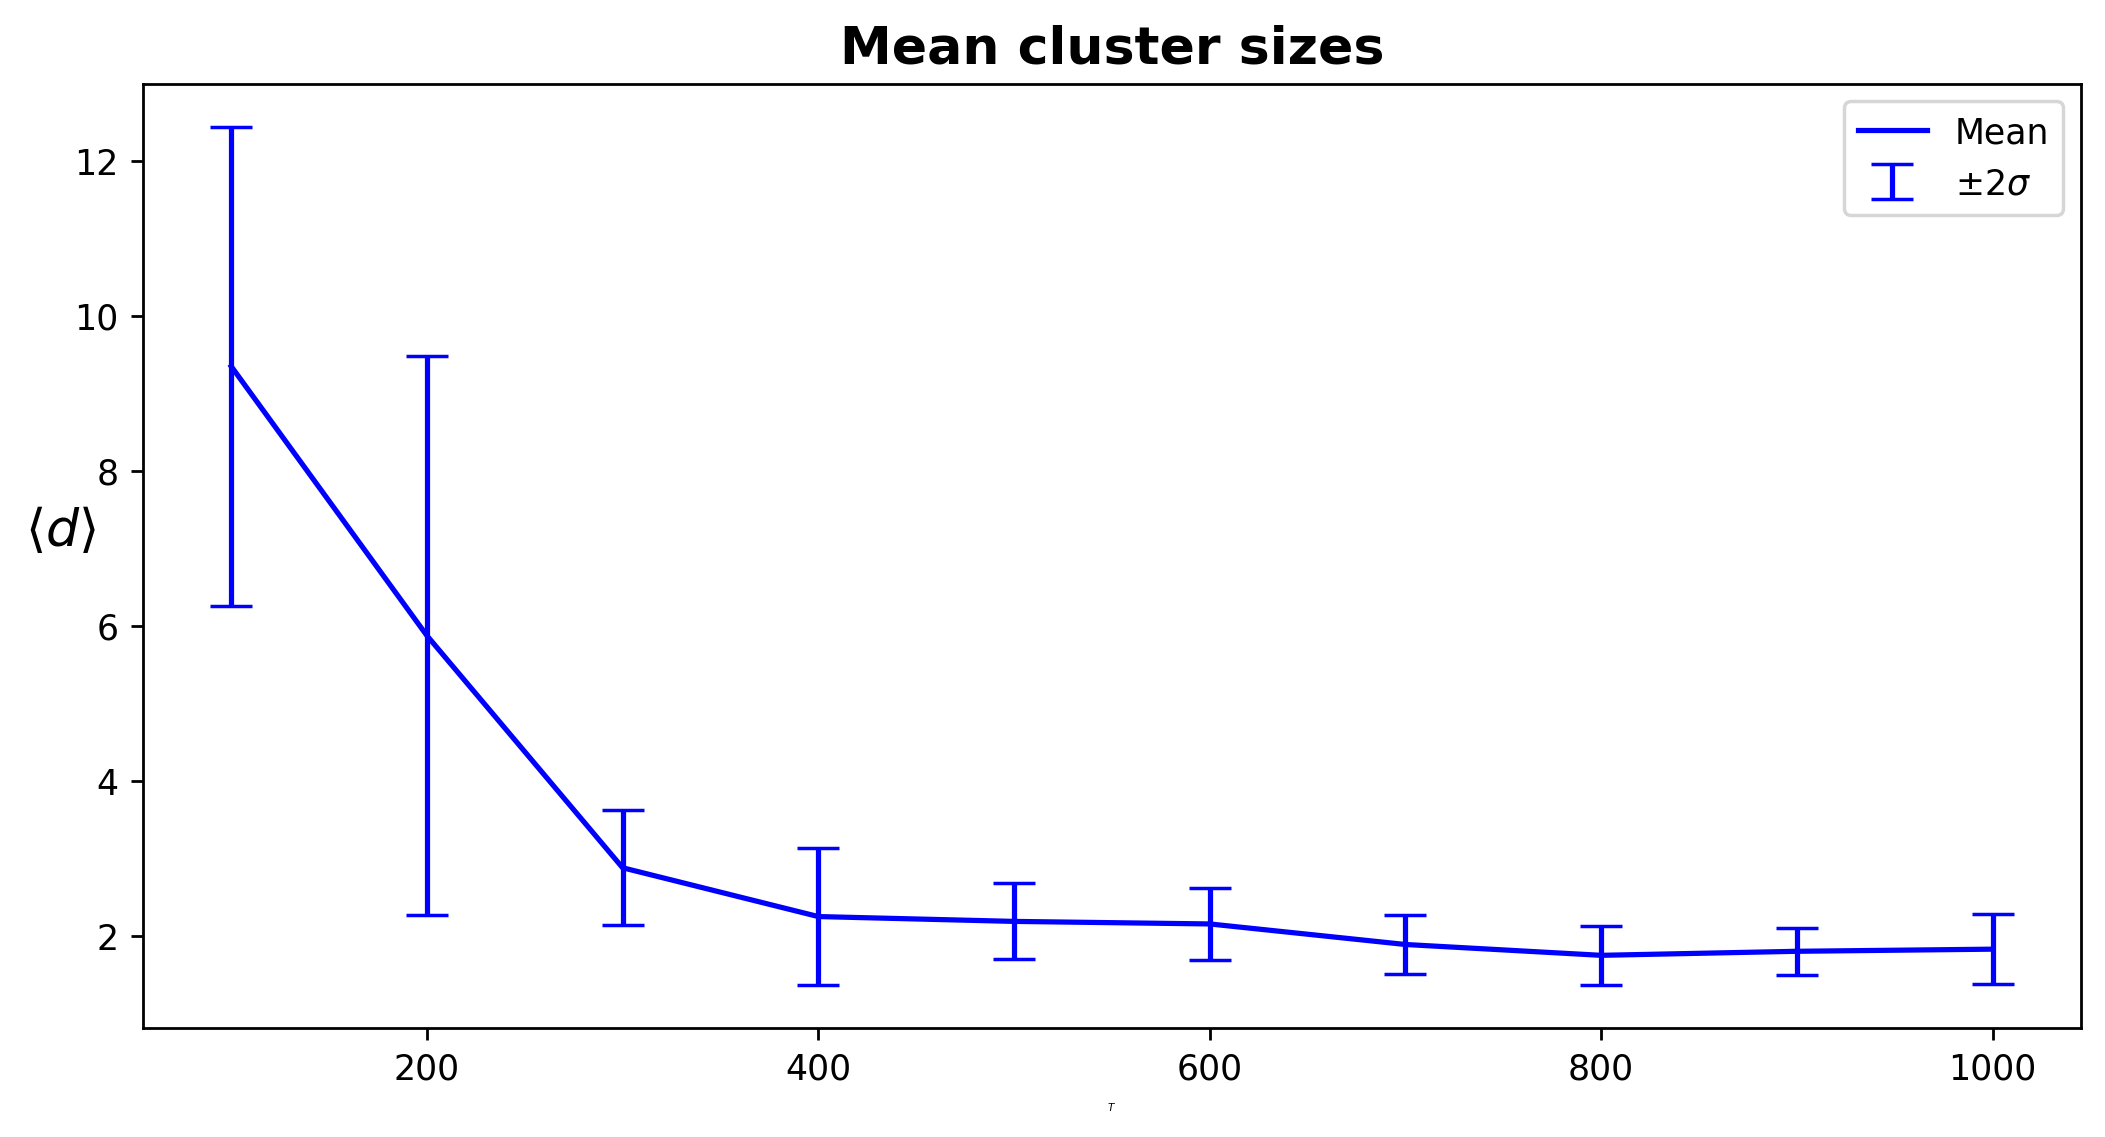

In [22]:
def plot_mean_cluster_sizes():
    # Unpack the relevant data  from the saved file
    simulation_data = np.load('mean_cluster_sizes.npz')
    mean_cluster_sizes = simulation_data['mean_cluster_sizes']
    
    mean_stddev = simulation_data['mean_stddev_arr']
    lower_cluster_sizes = mean_cluster_sizes-2*mean_stddev
    upper_cluster_sizes = mean_cluster_sizes+2*mean_stddev
    
    temps = simulation_data['temps']
    
    plt.rcParams['figure.figsize'] = [10, 5]
    
    # plt.plot(temps, lower_cluster_sizes,'--', label = "Lower standard deviation")
    plt.plot(temps,mean_cluster_sizes,label = "Mean", color='blue')
    # plt.plot(temps,upper_cluster_sizes,'--',label = "Upper standard deviation")
    plt.errorbar(
        temps,
        mean_cluster_sizes, 
        2*mean_stddev,
        linestyle = 'None',
        capsize=6,
        color='blue',
        label = "$\pm2\sigma$"
        )
    
    plt.legend()
    # Add title and labelnames
    plt.title("Mean cluster sizes", size = 15, weight="bold") 
    plt.xlabel(r"$T$", size = 3)
    plt.ylabel(r"$\langle d\rangle$", size = 15, rotation=0)
    
    # Showing the plot
    plt.show()  
plot_mean_cluster_sizes()

We see that $\langle d\rangle$ is larger at smaller $T$, because the monomers are able to minimize energy more efficiently with less thermal fluctuation. The way they reduce energy is by forming bonds to monomers with the opposite charge, and this results in clusters, so the average cluster size will increase.

As we can see from the plot including standard deviations ($\sigma$), the choice of $n = 10$ is sufficient to give accurate results. The two dotted lines are $\pm2 \sigma$, so we know that there is a $95.4\%$ certainity that the real value $\langle d\rangle$ is inside $\overline{d}\pm 2\sigma$, and the two lines are thin enough that we can be sure we capture the general data trend of very high values at $T = 100K$. A higher $n$ would have made the standard deviation lower (and therefore more accurate results), but it would also have dramatically increaced the computation time. For example, if we had used $n = 50$ insted of our $n = 10$, we would have needed to run $40 \ 000$ more Monte Carlo steps for every temperature, adding to a total of $400 \ 000$ more steps. This additional computation did as mentioned not seem neccecary for our purpose. 

Notice the large standard deviation at the lower temperature. This is because the random element is small, and the system may settle in a local energy minima. This implies that the initial grid configuration has a greater effect on the system's equilibrium at lower temperatures. When comparing the two grids, you can therefore see significantly different values at $T=100K$.


# 2.0 Modeling systems of polymers

A polymer consists of many monomers, bound to each other by covalent bonds. The number of monomers making up a polymer is denoted by $L$. We also consider the interactions between monomers in the same polymer to be zero.

Throughout this project, we will only study polymers that never break. 
> Recall: An unbroken polymer is defined as a polymer where there exists a path between any pair of monomers belonging to the polymer, where the path is piecewise horizontal or vertical, and that the path only touches grid points where there are monomers belonging to the same polymer.

To be able to conduct simulations of polymer systems, we first have to write the necessary functions to numerically generate and alter them. We will now create the framework to do this. 

## 2.1 Generating polymer grids
The method we will be using to generate polymer grids is similar to the one generating monomer grids. First we define an array containing the values of the enumerated polymers {1, -1, 2, -2, ..., M, -M}, we will refer to these identifying enumerations as *polymer numbers*. The reason for the alternating values is to give equal opportunities of growth for each of the positive and negative polymers. If we for example place all the positive polymers first, then the negative polymers would suffer from shortage of space. This would grow the negatives into different shapes than the positives, which would behave as a virtual artifact affecting the outcome of our simulation.


We will start by picking a random legal coordinate<a name ="legal"><sup>1</sup></a> in the grid, and place a monomer there. This is done by defining the value at the position in the grid as the current *polymer number*. Then one of the neighboring positions of this monomer is picked at random. 
If this position is legal, then a monomer is placed at its coordinate. By recording the neighboring positions of all recently placed monomers, we are able to always choose a new monomer at the edge of the polymer, which is analogous to the polymer "growing" from the ignition monomers position. When $L$ monomers are placed in the polymer, we will start the process anew, using the next *polymer number*.


The following function does as described, and will be used to generate initial grids for our simulations.

<br></br>
[1](#legal): We define a position to be legal, if there is no monomer there.

In [23]:
# define a function to call a random position
# this function returns a random (i, j) on an n*n grid
randomPos = lambda N:[np.random.randint(0, N), np.random.randint(0, N)]

def generate_polymer_grid(N, M, L):
    '''
        Will generate an n*n grid, then place M positive and M negative polymers
        in said grid. These polymers will be consisting of L monomers.
        The values in the outputted grid describe a biological system, and
        are defined as:
             0:  the solvent
            +1:  a monomer in the positivly charged polymer 1
            -1:  a monomer in the negativly charged polymer -1
            +2:  a monomer in the positivly charged polymer 2 
            -2:  a monomer in the positivly charged polymer -2 
            .
            .
            .
            +M:  a monomer in the positivly charged polymer M 
            -M:  a monomer in the positivly charged polymer -M 
        
        Input:
            N, integer. Number of points in the grid in i and j directions
            M, integer. Number of polymers
            L, integer. Number of monomers in each polymer
        Output:
            X, (n*n)-array. With 2M polymers, each containing L monomers.
    '''
    assert  (N*N > 2*M*L) #Making sure there is enough space on the grid to theoretically fill the grid. 

    # Define an (N*N)-array with zero-entries.
    X = np.copy( np.zeros(shape=(N, N)) )
        
    
    # Create an index array that alternates: [-1, 1, -2, 2, ... , -M, M]
    indexs = np.arange(0.5, M + 0.5, 0.5)
    indexs[::2] = np.arange(-1, -(M+1), -1)
    
    for i in indexs:
        p = randomPos(N)
        while (X[tuple(p)] != 0) :
            p = randomPos(N)
        
        monomer_positions = np.zeros(shape=(L, 2)) # an L*2-array containing monomer positions
        
        # The initial monomer is placen in the array of monomers, and
        # is placed in the grid
        monomer_positions[0] = p 
        X[tuple(p)] = i       
        
        # Create an array NN, which will contain all the possible positions for 
        # neighbors of the L number of monomers in the polymer.
        # This array is initially filled with the current initial point, this is 
        # to ensure that no point in the initail NN is valid. 
        # It will filled with valid positions as the polymer "grows"
        NN = [p]

        # Add the neighbors of the initial point.
        NN = np.append(NN, nearest_neighbors(X, p), axis=0)
        
        
        # This loop "grows" the polymer from the initial random point in the grid
        for j in range(1, L):
            j4 = j*4 #this simplifies som indexing, since many neighbor-arrays use multiples of 4*j
            # Now the next monomer will be randomly selected from the all possible neighbors
            # of all the monomers in the polymer


            unique_neighbors = np.unique(NN, axis=0)
            p_new = unique_neighbors[ np.random.randint(0, len(unique_neighbors)) ]

            
            t_m = time.time()
            while (X[tuple(p_new)] != 0):
                if abs(time.time() - t_m) > 6:
                    # In the odd case where the initial monomer is trapped between other polymers with 
                    # less than L points, we simply try again with recursion as this is rare anomaly.
                    print("Bad monomer placement, retrying") 
                    new_N, new_M, new_L = N, M, L
                    X = generate_polymer_grid(new_N, new_M, new_L)
                    return X

                p_new = unique_neighbors[ np.random.randint(0, len(unique_neighbors)) ]

            NN = np.append(NN, nearest_neighbors(X, p_new), axis=0)     # add the new neighbors of the POLYmer

            monomer_positions[j] = p_new  #add the new position to the array of monimer positions
            X[tuple(p_new)] = i     #set the value of the current POLYmer to the posion of the new MONOmer        
    
    return X


### 2.1.1 Observe the grid of polymers
It is useful to have a visual representation of the grid we will be working on. We therefore generate a test polymer.

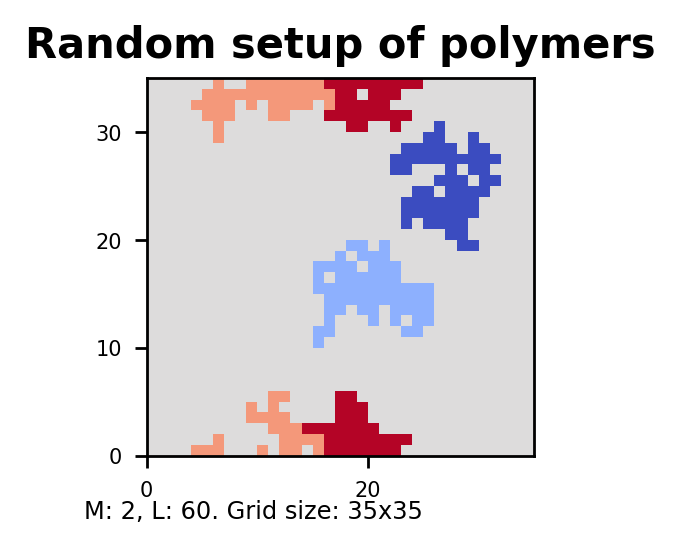

In [24]:
def test_generate_polymer():
    N = 35
    M = 2
    L = 60
    
    test_grid = generate_polymer_grid(N, M, L)

    plot_grid(test_grid, title="Random setup of polymers")

test_generate_polymer()

## 2.2 Moving polymers
Now that we have a grid of polymers, we would like to be able to move them. Similarly to monomers, the movement will be used by our Monte Carlo simulation.

Let's look into rigid movement, an up-scaled version of the monomers movement. All the monomers contained in the polymer will be moved one grid position following the movement convention previously defined. To implement this form of movement to our Monte Carlo algorithm, we need to find a way of checking if the move is legal. When talking about polymers, we define the move to be legal if the new position does not contain any <ins>other</ins> polymers.


### 2.2.1 Functions related to movement and checking of polymers
A useful auxiliary function to have, when working with polymers, is one that returns all the monomers positions in said polymer. In the following cell we have defined `monomers_in_polymer()` which does exactly this. Following that cell we define the `legal_rigid_move()` function that will determine the legality of a rigid move.

In [25]:
def monomers_in_polymer(X, polymer):
    '''
    Returns the positions of all the monomers in the given polymer
    Input:
        X: n*n-array of ints, descrives the system of polymers
        polymer: int, the polymer that is to be evaluated
    Output:
        monomers: (L*2)-array containing the positions of all the monomers in polymer polymer
    '''
    monomers = np.argwhere(X==polymer)
    return monomers

In [26]:
def legal_rigid_move(X, polymer, direction):
    '''
    This function evaluates if a proposed rigid move is legal.
    Input:
        X: n*n-array of ints, descrives the system of polymers
        polymer: int, the polymer that will be moved
        move_dir: int, the direction that the polymer will be moved in given as an integer:
            up = 0
            left = 1
            down = 2
            right = 3
    Output:
        legal_move: bool, True if move is legal
    '''
    monomers = monomers_in_polymer(np.copy(X), polymer)
    
    for m in monomers:
        m_neighbor = tuple( nearest_neighbors(np.copy(X), m)[direction] )
        if (X[m_neighbor] != polymer) and (X[m_neighbor] != 0):
            return False
    return True

### 2.2.2 Implementing the move

The implementation of rigid move is fairly simple, and similar to the move function of the monomers. The only difference being, we move many monomers, rather than one. To reduce runtime, it is good practice to reduce the number of if-statements, and especially, for-loops. In our rigid move function we will use the property that the direction is an integer. And even more useful, that a vertical direction is odd, and the horizontal direction is not odd. Using the following maps we would be able to update all the monomers positions in a single action.
$$
    f: \{0, 1, 2, 3\} \to \{-1, 0, 1, 0\}
$$ 
$$
    g: \{0, 1, 2, 3\} \to \{0, -1, 0, 1\}
$$

Using known functions we are able to define $f(n) = n-1(mod\ 2)$ and $g(n) = n-2(mod\ 2)$. Note that we must use a different modulus than the usual python `%` operator. This is because we wish to acquire negative numbers. By using $f$ on the coordinates on the i-axis, and similarly $g$ on the j-axis, we are able to offset any coordinate in the desired direction as shown for $m=(i_0,j_0)$:
$$
    m_{moved} \quad = \quad \hat i\big[i_0 \ + \ (direction-1 \ (mod \ 2))\big] \quad +\quad  \hat j\big[j_0 \ + \ (direction-2 \ (mod \ 2))\big]
$$
Simply apply this method to arrays of $i$ and $j$ coordinates, and we are able to swiftly move entire polymers.

In [27]:
def rigid_move(X, polymer, direction):
    '''
    This function rigidly moves a polymer in move_dir direction in the system X. This system is following
    the same convention as described in generate_polymer_grid().
    NOTE: This function assumes that the move is legal.
    Input:
        X: n*n-array of ints, descrives the system of polymers
        polymer: int, the polymer that will be moved
        direction: int, the direction that the polymer will be moved in given as an integer:
            up = 0
            left = 1
            down = 2
            right = 3
    Output:
    X_moved: n*n-array of ints, the new grid containing a moved polymer
    '''
    X_moved = np.copy(X)
    monomers = monomers_in_polymer(np.copy(X), polymer)
    
    axis0 = monomers[:, 0]
    axis1 = monomers[:, 1]
    
    # Set all monomer-positions to 0 in the grid
    X_moved[axis0, axis1] = 0
    
    # Using the maps f: {0,1,2,3} --> {-1, 0, 1, 0} by f(n) = (n-1) mod 2
    #            and g: {0,1,2,3} --> {0, -1, 0, 1} by g(n) = (n-2) mod 2
    # We are able to offset the direction in axis0 = axis0 + f(direction) and
    # axis1 = axis1 + g(direction)
    # The boundries of X are periodic by taking the modulus of the grids width
    X_moved[
        ( axis0 + np.fmod(direction-1, 2) )%len(X),
        ( axis1 + np.fmod(direction-2, 2) )%len(X)
     ] = polymer
    
    return X_moved

### 2.2.3 Running Monte Carlo simulation and presenting results
We are now ready to test our functions in a real simulation! The following cells start a Monte Carlo simulation of polymers that move rigidly. Notice that we save our simulation data using `np.savez()`, this is to be able to plot it at a later occasion, which we will do in the cell following the simulation.

In [28]:
def rigid_move_simulation():
    start_time = time.time()
    T = 200
    L = 15
    N = 30 
    M = 5
    N_s = 50000
    
    initial_grid = generate_polymer_grid(N, M, L)
    
    outgrid, outgrid_30K, energies = monte_carlo(N_s, T, np.copy(initial_grid), "poly-rigid", progress_update_steps = 5000)
    
    np.savez(
        'rigid_move_simulation', 
        initial_grid = initial_grid,
        outgrid = outgrid,
        outgrid_30K = outgrid_30K,
        energies = energies
        )
    print(f"Runtime: {(time.time() - start_time):.2f}s seconds.") # Prints the runtime of the function
# rigid_move_simulation()


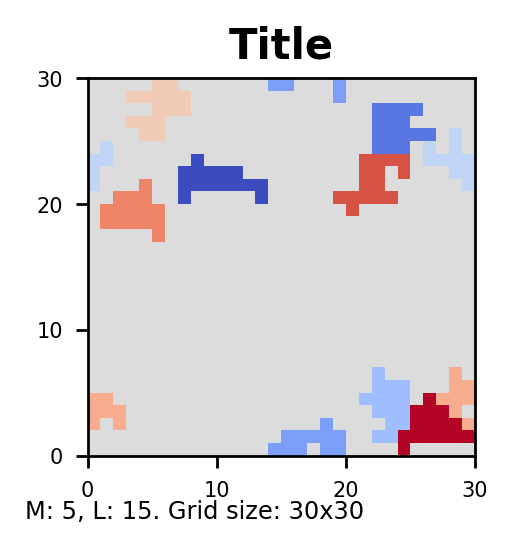

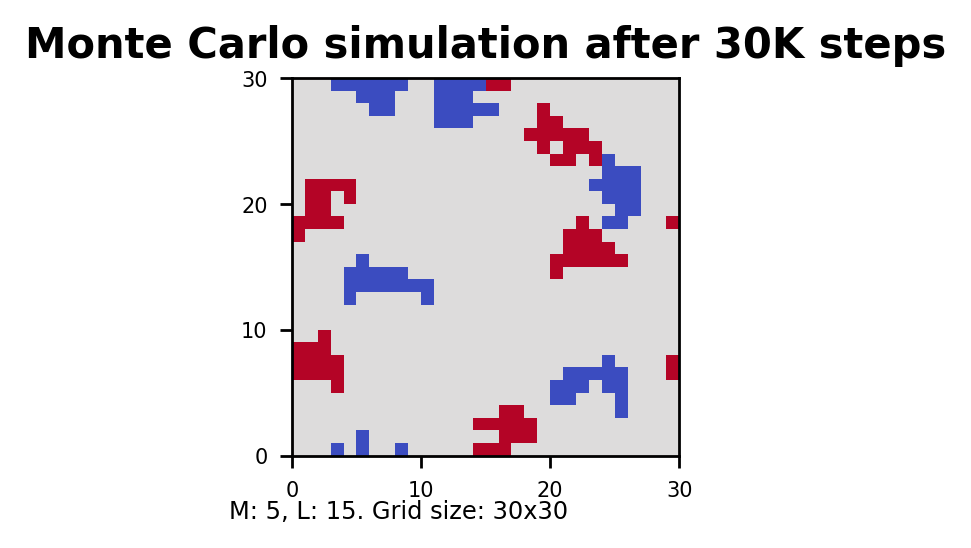

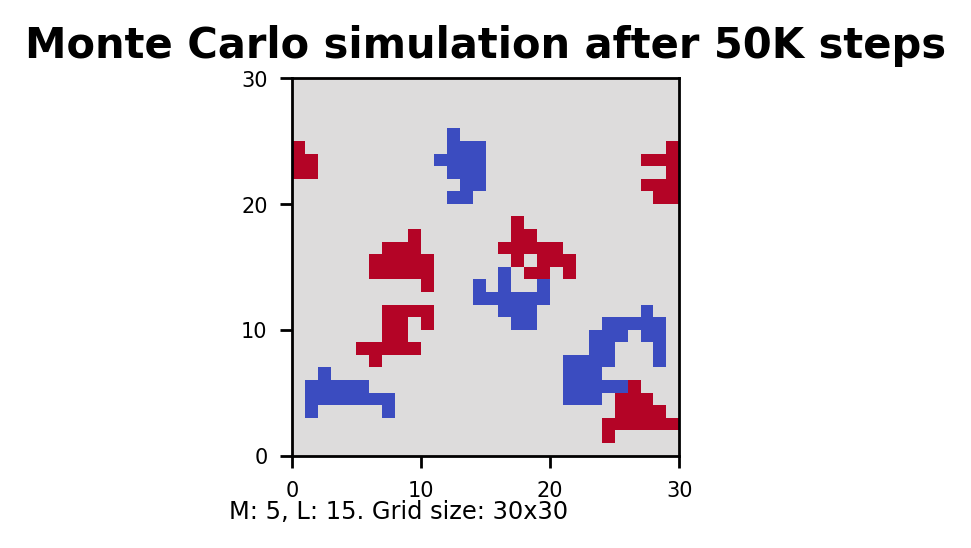

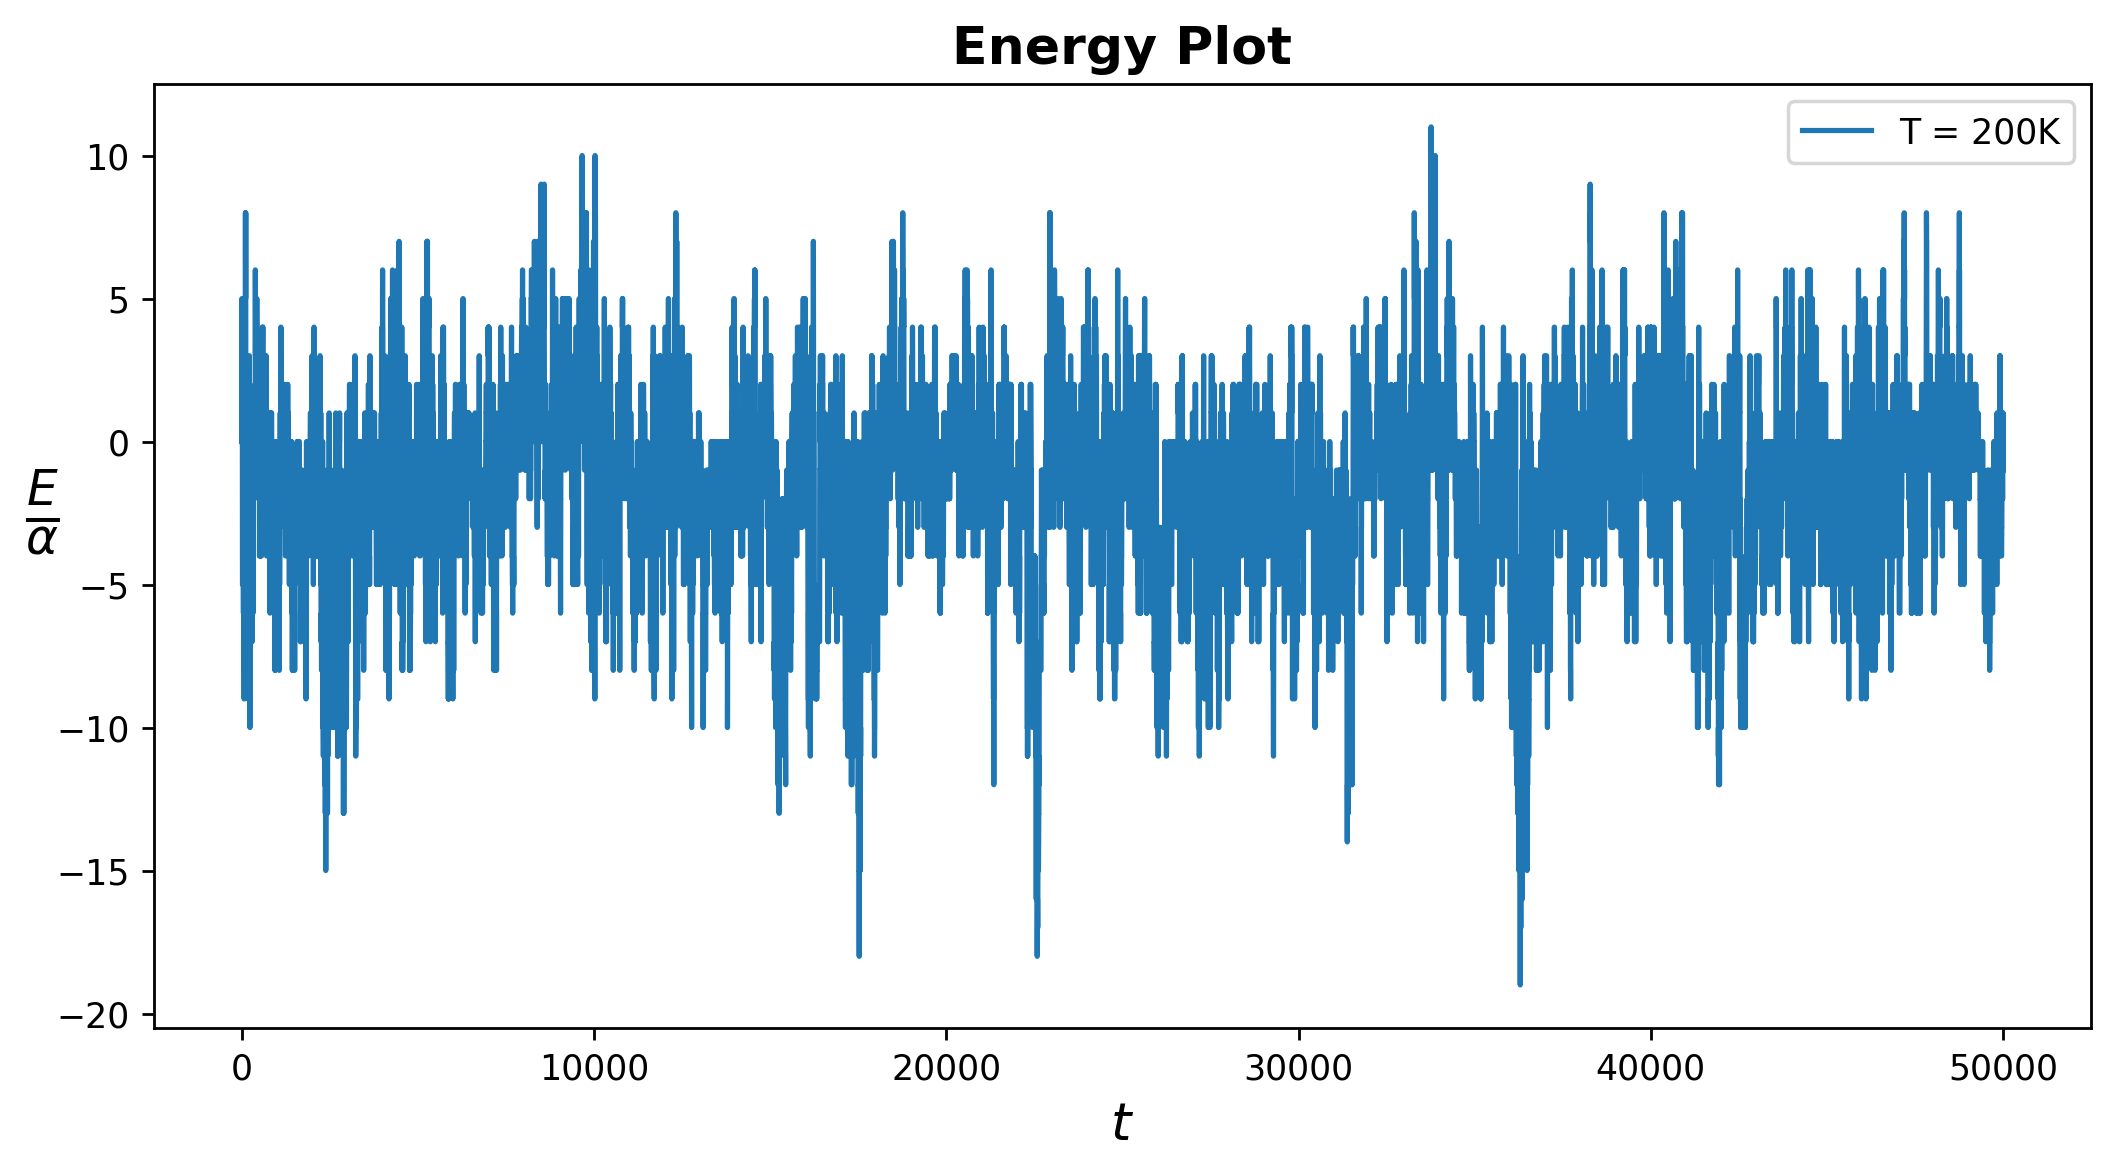

In [29]:
def plot_rigid_move_simulation():
    # Unpack the relevant data  from the saved file
    simulation_data = np.load('rigid_move_simulation.npz')
    initial_grid = simulation_data['initial_grid']
    outgrid, outgrid_30K = simulation_data['outgrid'], simulation_data['outgrid_30K']
    energies = simulation_data['energies']

    # Plotting
    plot_grid(initial_grid)
    plot_grid(outgrid_30K, True, "Monte Carlo simulation after 30K steps")
    plot_grid(outgrid, True, "Monte Carlo simulation after 50K steps")
    plot_energies(len(energies), [energies], [200])
    plt.show()

plot_rigid_move_simulation()

Here we see a plot after $30 \ 000$ iterations. It appears that the polymers are isolated, and unable to connect with each other.

From an algorithmic point of view, this is due to the nature of rigid move. The polymers edges are coarse, so even when positioned directly next to each other, they make few interactions. Even with the rigid nature of this move function, one might expect the polymers to at least interact with one polymer quite often. The reason this is as prevalent as one may expect is because in the Monte Carlo algorithm, the energy difference between two steps impacts how likely it is for a random movement to happen. The connection between two monomers from oppositely charged polymers does not lead to a particularly large energy difference, so it’s fairly common for the Monte Carlo algorithm to move them apart. This explains why they are largely isolated. We can also see this from the energy plot. The energy hovers around 0, although with large fluctuations. Zero energy corresponds to no contact between polymers of different charge. 

To compare the runtime, we show two simulations with as fair parameters as possible. Both have $N_s = 50 \ 000$, $T=200K$, and $N=15$. The monomer simulation has $M=33$. The polymer has $M=3$, $L=11$. So the total number of monomers will be equal, which should be the most fair circumstances for a comparison. 
The runtime for a $50000$ Monte Carlo simulation was about $159s$ for monomers, and $179s$ for polymers with rigid move. The slight increase in runtime can be explained by looking at the Monte Carlo algorithm. The move function, along with the legal move function is called in every iteration of the simulation, and the complexity of the polymer rigid move is slightly higher. The rigid move function involves some tricks to reduce runtime, so it’s not a large increase. equally fast. However, the legal move function for rigid move involves a for-loop, which leads to slightly slower runtime. 


In [30]:
def runtime_comparison():
    N_s=50000
    T = 200
    N = 15 
    M_polymer = 3
    L=11
    M_monomer = 33
    monomer_grid = generate_monomer_grid(N,M_monomer)
    polymer_grid = generate_polymer_grid(N,M_polymer,L)
    start_time = time.time()
    #monte_carlo(N_s,T,monomer_grid,"monomer")
    intermediate_time = time.time()
    #monte_carlo(N_s,T,polymer_grid,"poly-rigid")
    end_time = time.time()
    monomer_grid = generate_monomer_grid(N,M_monomer)
    polymer_grid = generate_polymer_grid(N,M_polymer,L)
    check_time = time.time()
    for i in range(10000):
        move_monomer(monomer_grid,1,1)
    check_intermediate_time = time.time()
    for i in range(10000):
        rigid_move(polymer_grid,1,1)
    check_end_time = time.time()
    print("Monomer simulation time: ", intermediate_time - start_time)
    print("Polymer simulation time: ", end_time - intermediate_time)
    print("Monomer check move time: ", check_intermediate_time - check_time)
    print("Polymer check move time: ", check_end_time-check_intermediate_time)
runtime_comparison()

Monomer simulation time:  0.0
Polymer simulation time:  0.0
Monomer check move time:  0.13987326622009277
Polymer check move time:  0.20881438255310059


## 2.3 Advanced movement

Moving polymers introduces a whole degree of complexity that we did not need to account for in monomers. Simply up-scaling their movement as rigid moves is not representative of a real world system. Polymers may flex and deform to their wish as long as they are connected. That is why we must improve upon our way of moving polymers. 

**Now introducing:** *the medium-flex-move<sup>TM</sup>* <br>
This new way of moving will allow the polymers to deform and shape each other. Which in turn sets the stage for larger surface areas between polymers and more interactions between them. 

**How does it work?**<br>
The polymers movement will be divided into a set of smaller moves. Each of these smaller moves are evaluated as separate cases. All these smaller moves are then combined into a large, single move. The details of the smaller moves are as follows. The polymer is separated into columns/rows along the direction of movement. Then each column/row is checked if it can legally move in the given direction. If *any* of the monomers in the column/row collide with a different polymer, the whole column/row stays in place.

It is worth mentioning this way of movement still lacks a degree of motion that is present in real world systems, namely rotation. In this project though, we will not be looking at rotation.

### 2.3.1 The medium flex-move
Using the properties of having an integer describe the direction (as mentioned in 2.2.2), we are able to slice the polymer into rows/columns in the movement direction. Let us call these rows/columns bars for simplicity. Moving the polymer is just a matter of iterating said bars and moving them if it is legal. The method for checking the legality is however quite a task, as we at each point in the iteration only know the positions of the current bar. And even more worrisome, the grid's periodic property. A way of avoiding the nature of the grids endpoints, is to move the bar from the axis $\{0, 1, 2, ..., N\}$ to $\{0, 1, 2, ..., 2N\}$ such that the polymer is in a way, not discontinuous over the border. This is done by adding $N$ to the points of the bar that are on the lower end of this range. A problem that arises is finding the part of the bar that is the actual split in the polymer (i.e if a polymer has stretched across the border on the right side and into the left side, we must find the points that differentiate the left from the right). Another example that raises this problem is a rake-shaped polymer stretching across the sides of the grid. If we wish to move this polymer right/left, it is split into horizontal columns. The columns across the "rake" part will now have multiple "discontinuities", however only one of which is the true break in the polymer.

**How do we go about solving these problems?**<br>
In nearly every case, given by the topology generated from our grid, and the length of our polymers. We know that there will *(nearly)* always be a slice of the grid, orthogonal to the bar, that does not contain **any** monomers of the current polymer. This can be thought of as creating a closed loop along the bars orthogonal axis on the torus that describes our grid. 
If the polymer does however, stretch all the way around the grid onto or over itself, then this solution does not hold. For $L<N$, we are certain that this will not happen, and even with a large $L=39$, this is extremely unlikely. We will however provide a solution, if this anomaly does occur. If this is the case, we have made the function `flex_move_brute()` that "brute forces" the move by iterating over every monomer in the polymer. This function is called, if `flex_move_slice_method()` is asked to move a polymer that stretches across the entire grid.

**The slice method**<br>
The grids points along the bars axis, that are not themself members of the bar, describe the discontinuities of the bar. By iterating an axis orthogonal to the bar, at each of these discontinuities, we are able to find the one that does not contain any monomers of the same polymer. We will refer to this point, on the bars axis, as the bars' true break point. In the following image we can see the slice method working on `bar 1`, and has found the true break point to be at `j = 5`.
<br>
<br>
<img 
    src="flex_slice_figure.png" 
    alt="figure" 
    style="
        width: 400px;
        display: block;
        margin-left: auto;
        margin-right: auto;
     "/>
<br>

Now that we have acquired the true break point in the bar,  we are able to add $N$ to all the positions on the "lower" side of this breakpoint. Following our example, this would be all the positions of  `bar 1` that are less than `j = 5`, i.e. `[0, 2, 3]`. This essentially moves the bar to a domain where it is not cut off by the edge of the grid. In this domain we can determine the bars leading surfaces in the movement direction, and check for potential collisions. If there are none, the whole bar is moved rigidly in its movement direction, then placed back to its original domain. And the process is repeated for every bar in the polymer. 


One might ponder if all this fuss is better, or even faster, than simply iterating through all the monomers in the polymer that is to be moved. We are iterating several times, however we are swiftly utilizing numpys array functions that run in C, a much faster language. By moving the iterations to numpy we are dramatically reducing computational runtime.


In [31]:
def flex_move_slice_method(X, polymer, direction):
    '''
    This function (medium) flexably moves a polymer in move_dir direction in the system X. This system is 
    following the same convention as described in generate_polymer_grid().
    NOTE: This function assumes that the move is legal.
    This function works by slicing the polymer into 'bars' along the colums/rows in the movement direction
    then it checks if the current bar is elligable to move in the movement direction by checking the edge of
    the bar. If it is elligable to move, the bar is moved one step in the movement direction, the 
    new position of the bar is added in a copy of the original grid. This is to preserve the functionality of 
    findig the edge of the bar. 
    This is done to all the bars in the polymer by a short number of iterations. The number of steps is the 
    amount of bars in the movement direction, or,  the width of the polymer projected onto a line perpendicular to the
    movement direction.
    
    Input:
        X: n*n-array of ints, descrives the system of polymers
        polymer: int, the polymer that will be moved
        direction: int, the direction that the polymer will be moved in given as an integer:
            up = 0
            left = 1
            down = 2
            right = 3
    Output:
    moved_X: n*n-array of ints, the new grid containing a flexably-moved polymer
    '''
    moved_X = np.copy(X) # make a separate grid containing the moved polymer
    monomers = monomers_in_polymer(moved_X, polymer)
    n = len(moved_X)
    
    # Start by slicing the polymer into "bars" WITH the proposed direction, by defining a plane
    # that is 0 for i-direction and 1 for j-direction
    plane = direction % 2
    
    # Then define two axis:  axis0 along the plane, and axis1 orthogonal to axis0
    axis0 = monomers[:, (plane + 1)%2]
    axis1 = monomers[:, plane]
    
    #print(axis0,  axis1)
    #print(axis0 + np.fmod(direction-1, 2), axis1 + np.fmod(direction-2, 2))
    #print('\n\n')
    
    for ax in np.unique(axis0):
        
        ax_index = np.flatnonzero( axis0==ax ) # This defines the elements allong axis1 at the current index ax in axis0
        bar = axis1[ax_index]
        
        
        # Define the position next to the edge of the bar in the movement direction, this will be used to 
        # check weather the bar is allowed to move.
        # Here i am using the map f: {0, 1, 2, 3} --> {0, 0, 1, 1} by f(n) = floor( n - 0.5*n ). Then the 
        # said position is found by: -1 + min(bar) + (len(bar) + 1 )*f(direction)
        #                            ^                           ^
        #       This is to offset -1 up/left                This is to offset +1 down/right
        #
        # This is all assuming the polymers arent at the edge of the gris. To take this into account
        # all indices in the current bar to the left of a discontinuity of the polymer are added n (width of grid).
        # This ensures that the bar is continous, and the edge is found as described above. After the edge is
        # found, we take the modulus of n (width of grid) to return the bar to its original position.             
        
        
        # Find the discontinuity that truly is the break in the polymer by checking along 
        # axis1 (orthogonal to axis0) on all discontinuities. This is done by transposing
        # X *IF DIRECTION IS HORIZONTAL* otherwise, X is left be. The reason for doing this is 
        # to make X[discontinuities, :] allways orthogonal to the bar axis, as this is easyer to work with.
        # Note that X_trans is ONLY used in the prossess of checking the legality of the move.
        
        X_trans = np.copy(np.transpose(moved_X, [plane, (plane + 1)%2]))
        
        
        # First define the position of the discontinuities on the grid, then define an array containing a
        # whole slice of X (orthogonal to the bar). Then find the first slice that does not contains any monomers 
        # of the same polymer. Finally we can define the part of the bar that is "before" the true 
        # break in the polymer
        
        # All points along axis0 that are not the bar, are checked
        grid_discontinuities = np.setdiff1d( np.arange(0, n), bar )
        ortho_discontinuities = np.array( X_trans[grid_discontinuities,:] , dtype='int64')

        # This will fail if the polymer streches accross the whole grid.
        # If this happens, we call for flex_move_brute() to save the day.
        try:
            poly_break_index = np.nonzero((ortho_discontinuities != polymer).all(axis=1))[0][0]
        
        except:
            return flex_move_brute(X, polymer, direction)

        
        ########################################################################################
        # From this point the bar is continous, and lives in the domain {0, 1, ..., 2n}
        
        bar[ np.flatnonzero(bar < grid_discontinuities[poly_break_index]) ] += n        
        bar_length = np.max(bar) - np.min(bar) + 2  # Note: this takes the offset into account (as mentioned in the cmt. over)      


        not_bar = np.setdiff1d( np.arange(np.min(bar)-1, np.max(bar)+2), bar)
        not_bar_diff = np.diff(not_bar)
        edges = not_bar[ np.flatnonzero( abs(not_bar_diff) > 1) + int(np.floor(direction - 0.5*direction)) ]%n
        
        
        # From this point the bar is back to the domain {0, 1, ..., n}
        bar = bar % n
        #######################################################################################
       

        if (X_trans[edges, ax] == 0).all():
            
            moved_X[
                bar*( (plane+1)%2 ) + ax*plane,
                ax*( (plane+1)%2 ) + bar*plane
             ] = 0
            
            moved_X[
                ( (bar*( (plane+1)%2 ) + ax*plane)  + np.fmod(direction-1, 2) )%n,
                ( (ax*( (plane+1)%2 ) + bar*plane)  + np.fmod(direction-2, 2) )%n
             ] = polymer
               

    
    return moved_X

These next functions are used as the brute force-solution we mentioned earlier. Which will be called in the unlikely situation of a polymer streching accross the whole grid.

In [32]:
def check_for_legal_on_sides(X_input, polymer, polymer_pos, direction):
    '''
    Helping function for the flex_move-func. Checks if it is safe to move a ploymer when some of its monomers are on
    one of the edges of the grid.
    
    
    The reasoning behing this check is that a polymer needs the neccecarty 
    space when it travels from one side of the grid.
    
    F.ex.
    Column number 2 from the left in the grid
    [[0, 1, 0, 1], 
    [0, 0, 1, 1], 
    [1, 3, 1, 1],   
    [0, 1, 0, 1]]
    will NOT be able to move upwards because of the 3-value "blocking".
    
    If we would try to move the 1-polymer upwards, we get the grid.
    [[0, 1, 1, 1], 
    [1, 0, 1, 1], 
    [0, 3, 0, 1],   
    [0, 1, 0, 1]]
    
    Input:
        X_input: NxN-array of ints, descrives the system of polymers
        polymer: int, the polymer that will be moved
        direction: int, the direction that the polymer will be moved in given as an integer:
            up = 0
            left = 1
            down = 2
            right = 3
    Output:
        Boolean. True if the move is allowed, and False if it isnt.
    '''
    
    # Finding the x- and y-value of the posistion.
    x_pos = polymer_pos[1]
    y_pos = polymer_pos[0]
    
    moved_X = np.copy(X_input) # Makes a new grid that is a duplicate of the grid from the input.
    N = len(moved_X) # Integer describing the size of the NxX-grid
    
    
    # Checking which direction the polymer is going to be moved in, and running different loops based on the direction.
    # Only one of the direction-loops will be commented, but there are the same principles for all of them.
    
    # Inside these loops are only a simple iteration to checking of the values in the same grid/column is 
    # the same polymer as the one we are moving, another polymer, or a 0-value.
    # Then it is related to wether the move is allowed or not. 
    if direction == 0:
        for i in range(N):
            if moved_X[N-1-i][x_pos] != 0 and moved_X[N-1-i][x_pos] != polymer:
                for j in range(i):
                    if moved_X[N-1-j][x_pos] == 0:
                        return True
                return False
        return True
            
    if direction == 1:
        for i in range(N):
            if moved_X[y_pos][N-1-i] != 0 and moved_X[y_pos][N-1-i] != polymer:
                for j in range(i):
                    if moved_X[y_pos][N-1-j] == 0:
                        return True
                return False   
        return True
    
    if direction == 2:
        for i in range(N):
            if moved_X[i][x_pos] != 0 and moved_X[i][x_pos] != polymer:
                for j in range(i):
                    if moved_X[j][x_pos] == 0:
                        return True
                return False
        return True
    
    if direction == 3:
        for i in range(N):
            if moved_X[y_pos][i] != 0 and moved_X[y_pos][i] != polymer:
                for j in range(i):
                    if moved_X[y_pos][j] == 0:
                        return True
                return False  
        return True

In [33]:
def flex_move_brute(X_input, polymer, direction):
    '''
    This function (medium) flexably moves a polymer in move_dir direction in the system X. This system is 
    following the same convention as described in generate_polymer_grid().
    NOTE: This function assumes that the move is legal.
    
    Input:
        X_input: NxN-array of ints, descrives the system of polymers
        polymer: int, the polymer that will be moved
        direction: int, the direction that the polymer will be moved in given as an integer:
            up = 0
            left = 1
            down = 2
            right = 3
    Output:
    moved_X: NxN-array of ints, the new grid containing a flexably-moved polymer
    '''
    
    # Makes a new grid that is a duplicate of the grid from the input. This is to avoid any
    # potential problems related to copying of a grid, and/or global vs. local variable names.
    moved_X = np.copy(X_input)
    
    N = len(moved_X) # Integer describing the size of the NxX-grid
     
    # Uning the monomers_in_polymer-function to create a (L*2)-array containing 
    # the positions of all the monomers in polymer polymer
    monomers = monomers_in_polymer(np.copy(moved_X), polymer)
    
    
    # To make the later loops faster by needing fewer iterations, we find the rows and columns that contain polymers.
    rows_with_monomers = []
    columns_with_monomers = []
    
    for monomer in monomers:
        x_coord = monomer[1]
        y_coord = monomer[0]
        
        if x_coord not in columns_with_monomers:
            columns_with_monomers.append(x_coord)
        if y_coord not in rows_with_monomers:
            rows_with_monomers.append(y_coord)
    

    # Checking which direction the polymer is going to be moved in, and running different loops based on the direction.
    # Only one of the direction-loops will be commented, but there are the same principles for all of them.
    
    if direction == 0: 
        # Iterating through every column. 
        for i in range(N):
            exceptions1 = []
            exceptions2 = []
            # Running if-statement if out current column are one of the ones that contains the polymer that is giong to be moved. 
            if i in columns_with_monomers: 
                
                # Running the funciton check_for_legal_on_sides() to check some of the instanced where a move mightbe problematic.
                if check_for_legal_on_sides(moved_X, polymer, [0, i], direction) == False:
                    exceptions2.append(i)
                    
                # If there is a polymer situated at the top row of the grid it will remove the polymer and save the location to exceptions1.
                elif moved_X[0][i] == polymer:
                    moved_X[0][i] = 0
                    exceptions1.append(i)
                    
                # Iterates through every row (except for the top one), and moving the polymers one row upwards (if the move if allowed). 
                for j in range(1, N):
                    if moved_X[j][i] == polymer and moved_X[j-1][i] == 0:
                        moved_X[j-1][i] = polymer
                        moved_X[j][i] = 0
            
            # Adds the polymers we removed from the top row to the bootom row of the grid
            for i in exceptions1:
                moved_X[N-1][i] = polymer
    
    elif direction == 1: 
        for i in range(N):
            exceptions1 = []
            exceptions2 = []
            if i in rows_with_monomers:
                if check_for_legal_on_sides(moved_X, polymer, [i, 0], direction) == False:
                    exceptions2.append(i)
                elif moved_X[i][0] == polymer:
                    moved_X[i][0] = 0
                    exceptions1.append(i)
                for j in range(1, N):
                    if moved_X[i][j] == polymer and moved_X[i][j-1] == 0:
                        moved_X[i][j-1] = polymer
                        moved_X[i][j] = 0
            for i in exceptions1:
                moved_X[i][N-1] = polymer
    
    elif direction == 2: 
        for i in range(N):
            exceptions1 = []
            exceptions2 = []
            if i in columns_with_monomers:
                if check_for_legal_on_sides(moved_X, polymer, [N-1, i], direction) == False:
                    exceptions2.append(i)
                elif moved_X[N-1][i] == polymer:
                    moved_X[N-1][i] = 0
                    exceptions1.append(i)
    
                for j in range(N-2, -1, -1):
                    if moved_X[j][i] == polymer and moved_X[j+1][i] == 0:
                        moved_X[j+1][i] = polymer
                        moved_X[j][i] = 0
            for i in exceptions1:
                moved_X[0][i] = polymer
    
    elif direction == 3: 
        for i in range(N):
            exceptions1 = []
            exceptions2 = []
            if i in rows_with_monomers:
                if check_for_legal_on_sides(moved_X, polymer, [i, N-1], direction) == False:
                    exceptions2.append(i)
                elif moved_X[i][N-1] == polymer:
                    moved_X[i][N-1] = 0
                    exceptions1.append(i)

                for j in range(N-2, -1, -1):
                    if moved_X[i][j] == polymer and moved_X[i][j+1] == 0:
                        moved_X[i][j+1] = polymer
                        moved_X[i][j] = 0
            for i in exceptions1:
                moved_X[i][0] = polymer
    # Returnes the new grid where the polymer has been moved one step.
    return moved_X

### 2.3.2 The polymers break!

By simply following the rules of medium-flex-move, we are able to break the polymer. This is of course not ideel, as we would like to model non-breaking polymers in our simulation. A way of solving this is to make a function that checks whether the polymer is broken, and implement it into the Monte Carlo function. 

The following funciton has some similarities to `flex_move_slice_method()`. We want to check if a given polymer is broken. This can be done by first patching it together if it spans accross the the border. This is done by finding the break points in the polymer, where the method for doing this is similar to the previous mentioned method. If we then place the patched together polymers in a new, empty `2N*2N` grid, we can then take advantage of a usefull function from the scipy package, namely `ndimage.label()`. This function takes in a grid, and indexes the "islands" (disconnected clusters) in said grid. We can then check number of islands of one polymer. If there are more than one, then the polymer is broken.

The follwing function uses this method to determin wether the polymer is broken, and returns True if this is the case.

In [34]:
def broken_polymer(X, polymer):
    '''
    This function determins wheather the given polymer is broken.
    The method for doing this is to first "patch" the polymer together and place it in the center of
    a 2N*2N-grid containing zeros. Then use scipys ndimage.label function to determine the number of "islands". 
    If the number of islands is greater that one, the polymer is broken.
    
    
    Input:
        X: n*n-array describing the system
        polymer: int, which polymer that is to be checked
    Output:
        broken: bool, True if polymer is broken, false otherwise
    
    '''
    X_copy = np.copy(X)
    monomers = monomers_in_polymer(np.copy(X_copy), polymer)
    n = len(X)
    
    monomers_i = monomers[:, 0]
    monomers_j = monomers[:, 1]
    
    # These define the break in the polymer on the i and j axis
    break_i = np.setdiff1d( np.arange(0, n), np.unique(monomers_i) )[0]
    break_j = np.setdiff1d( np.arange(0, n), np.unique(monomers_j) )[0]    
    
    
    ### From this point the polymer is at the center of a 2N*2N coordinate system.
    monomers_i[ np.flatnonzero(monomers_i < break_i) ] += n
    monomers_j[ np.flatnonzero(monomers_j < break_j) ] += n
    
    # Here the polymer is placed in a 2N*2N-grid containing zeros, the polymer values are 1.
    X_eval = np.zeros(shape=(2*n, 2*n))
    X_eval[monomers_i, monomers_j] = 1
    
    #plot_grid(X_eval)
    
    
    # Using the scipy.ndimage.label function, we are able to label the different islands. Note that
    # we specify the diagonals as not connected.
    # If there only is one island, the polymer is not broken
    if label(X_eval, [[0, 1, 0], 
                      [1, 1, 1], 
                      [0, 1, 0]])[1] == 1:
        return False
    return True

### 2.3.3 Yet another Monte Carlo simulation, this time with flexable polymers
We can now let the run the Monte Carlo-simulation using the medium flexibility move as out way to move the polymers (and checking after every step if the polymer has been broken). This way, we can do an even more realistic simulation of the formation of membrane-leff organelles than we did using rigid move.

In [35]:
def medium_flex_simulation():
    N = 30
    M = 5
    L = 30
    N_s = 25000
    
    T = 200
    
    initial_grid = generate_polymer_grid(N, M, L)

    outgrids, outgrid, energies = monte_carlo(N_s, T, np.copy(initial_grid), "poly-flex", progress_update_steps = 2000)
    
    
    np.savez(
        'medium_flex_simulation', 
        initial_grid = initial_grid,
        outgrids = outgrids,
        outgrid = outgrid,
        energies = energies
        )

# medium_flex_simulation()

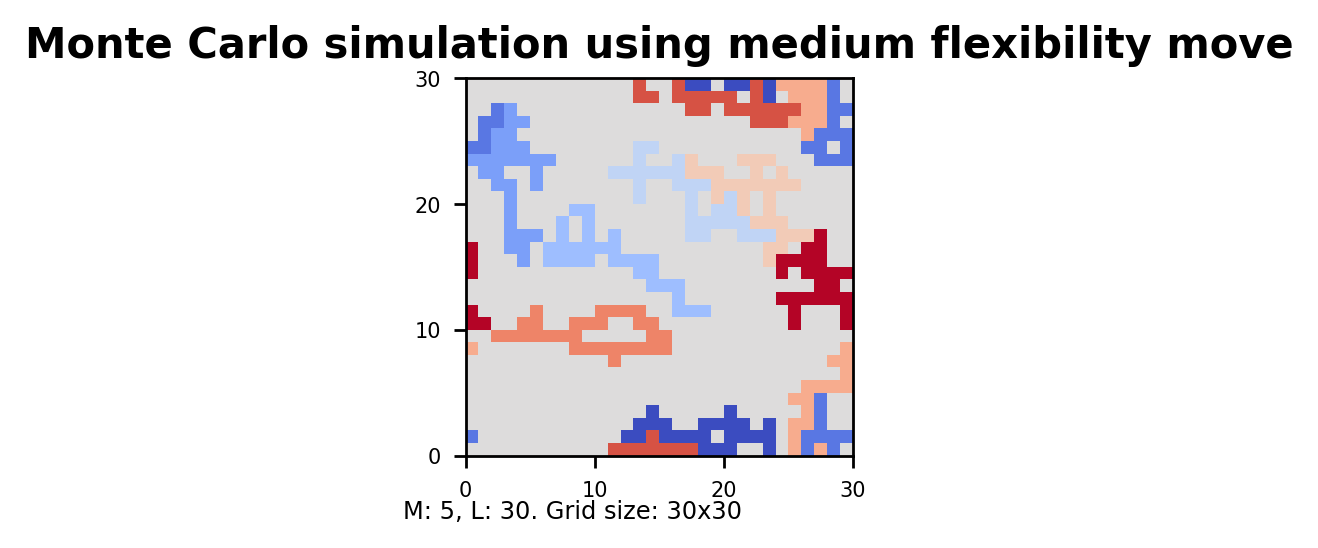

ValueError: x and y must have same first dimension, but have shapes (25000,) and (50000,)

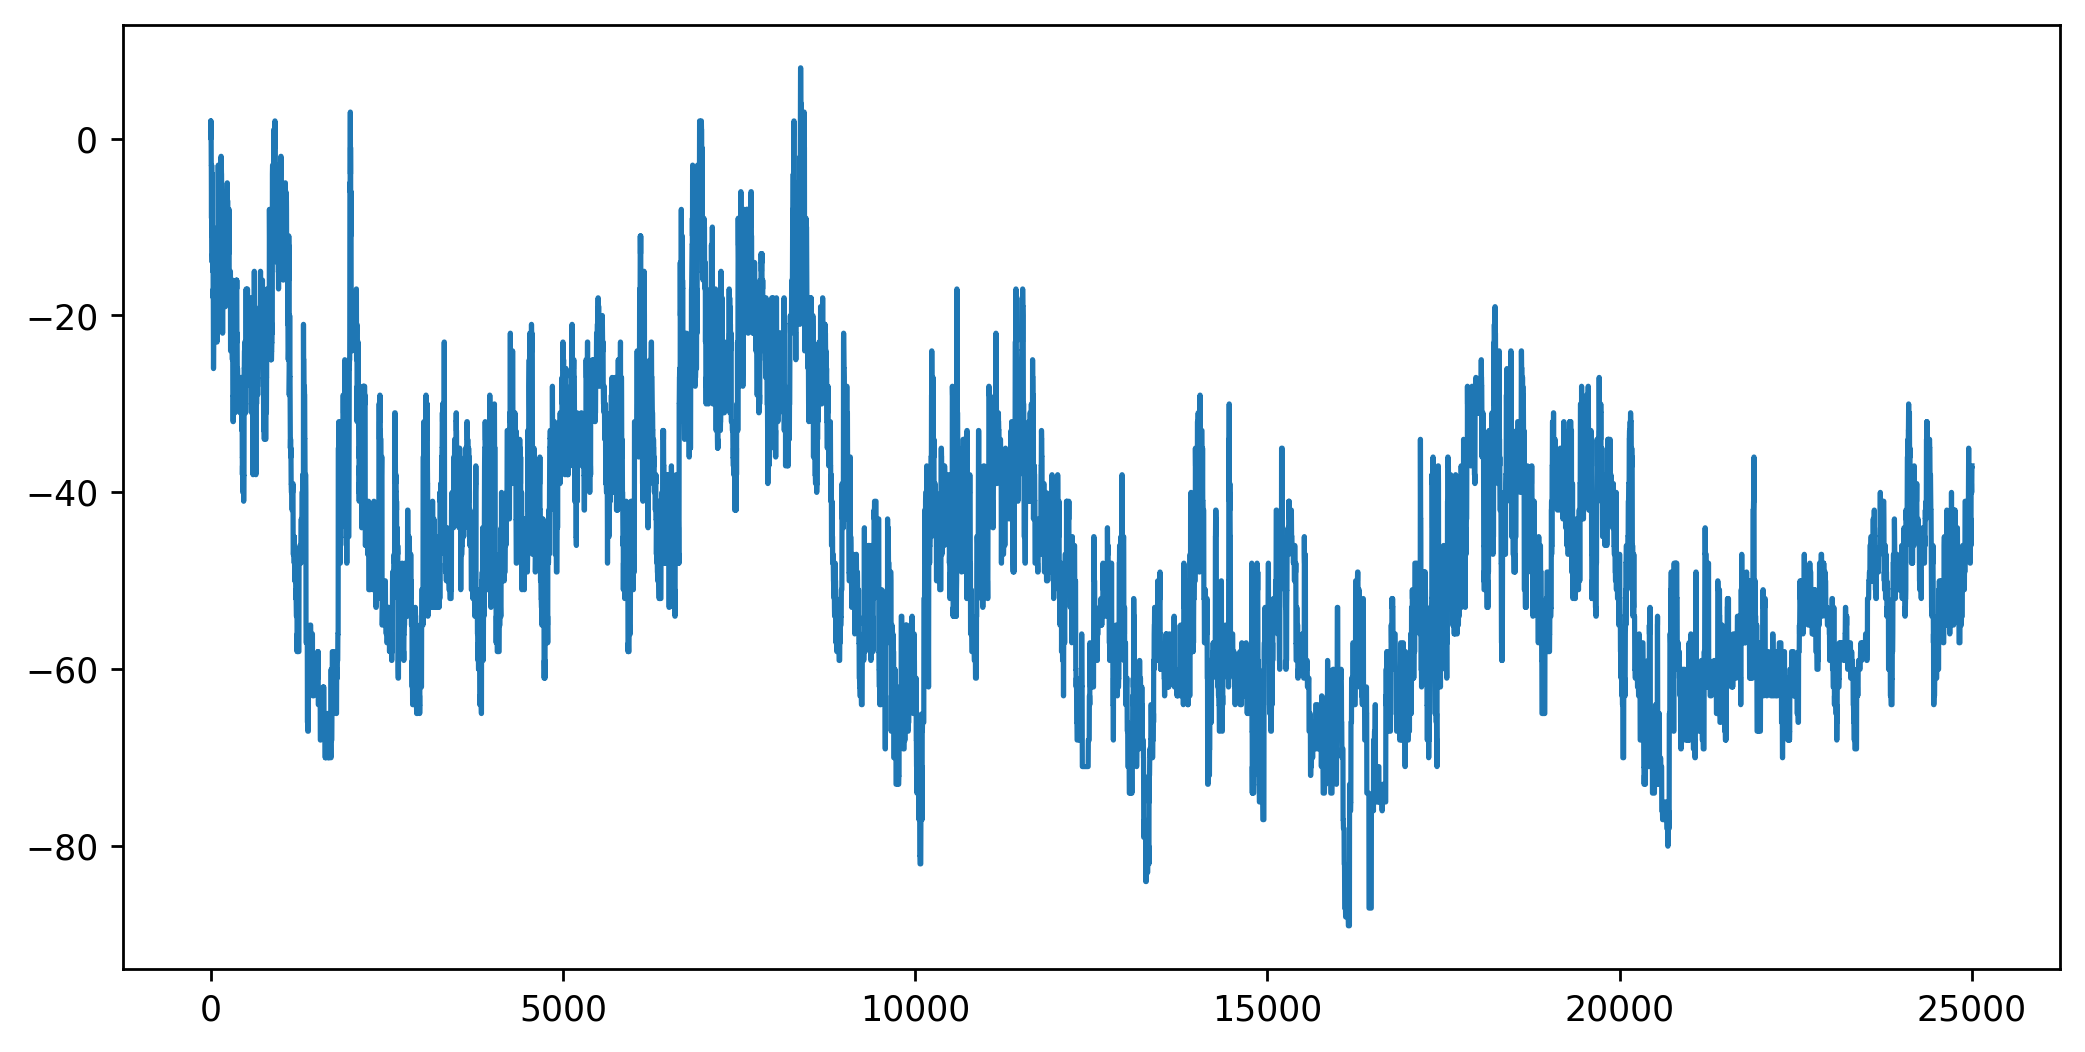

In [43]:
def plot_medium_flex_simulation():
    # Unpack the relevant data  from the saved file
    simulation_data = np.load('medium_flex_simulation.npz')
    initial_grid = simulation_data['initial_grid']
    outgrids, outgrid = simulation_data['outgrids'], simulation_data['outgrid']
    energies = simulation_data['energies']
    
    simulation_data = np.load('rigid_move_simulation.npz')
    energies_rigid_move = simulation_data['energies']

    # Plotting
    plot_grid(outgrid, False, "Monte Carlo simulation using medium flexibility move")
    plot_energies(len(energies), [energies, energies_rigid_move], [200, 200], ["Medium flexibility move", "Rigid move"])
    plt.show()

plot_medium_flex_simulation()

When using flex move, we see that the polymers interact a lot more than with our earlier rigid move simulations, as they now are able to deform in order to lower the system's energy as much as possible. We see from the energy plot that the energy is significantly lower than in the rigid move simulations. The energy of the system relates physically to the system in the sense that two oppositely charged polymers hugging each other is a form of energy minimization, and that is exactly what happens in the plot.

## 2.4 How big are the clusters?
At last, we will study how the size of polymers impacts the formation of organelles. The quantities we will study are the average cluster size divided by L and the average number of clusters, denoted as $\langle d\rangle / L$ and $\langle m\rangle$, as functions of $L$. Both of these are closely related to the liquid-liquid phase separation drives the formation of the organelles. In addition, we will also observe the standard deviation of these quantities.


### 2.4.1 Mean cluster size for single grid
To calculate $\langle d\rangle / L$ we firstly create a function that determines the mean cluster size of a single grid. This is done by summing the size of each cluster in the grid, and then dividing by the number of clusters.

In [37]:
def mean_cluster_size(grid):
    '''
    Function that equates the mean cluster size of a grid.
    Input:
        grid: NxN grid for which we will equate the mean cluster size.
    Output:
        The mean cluster size of the grid.
    '''
    mean_cluster_sizes = []
    grid = cluster_grid(grid)
    indexes = np.nonzero(np.copy(grid))
        
    for i in np.unique(grid[indexes]):
        mean_cluster_sizes.append((grid[indexes]==i).sum())
   
    return np.average(mean_cluster_sizes)

### 2.4.2 Mean number of clusters for single grid
To calculate  $\langle m\rangle$  we create a function that determines the mean number of clusters for single grid. This is done by summing the mean number of clusters for in the grid, and then dividing by the number of clusters.

In [38]:
def mean_number_of_clusters_constant_L(grid):
    values = []
    number_of_values = []
    
    positions = np.argwhere(np.copy(grid))
    for pos in positions:
        temp_value = grid[pos[0]][pos[0]]
        for i in range(len(values)):
            if values[i] == temp_value:
                number_of_values[i] += 1
            else:
                values.append(temp_value)
                number_of_values.append(1)
    return np.average(values)

def clusters_amount(grid):
    cluster_amount = np.array([])
    grid = cluster_grid(grid)
    indexes = np.nonzero(grid)
    return np.max(grid[indexes])

### 2.4.4 Investigating cluster formation for differently sized polymers
We now utilize our funcitons to calculate the two quantities for 13 evenly spaced $N$ values between $3$ and $39$. 

In [39]:
def mean_cluster_sizes_medium_flex(N, M, n, T, lengths, t_equil):
    '''
    Function that equates the mean cluster size for an array of different T values
    Input:
        N: The size of the grid.
        M: The number of monomers.
        n: The number of measurements of the cluster size for each temperature
        temps: Array of temperatures given in Kelvin.
    Output:
        mean_cluster_sizes: Array with the mean cluster sizes for the different temperatures.
        mean_cluster_deviations: Standard deviation of mean cluster size
    '''
    t_r = 1000 # The number of steps between each measurement.
    
    # Creating empty arrays that will be filled with the mean cluster sizes, mean number of cluster and standard deviations.
    mean_cluster_sizes = np.zeros(len(lengths)) 
    mean_cluster_deviations = np.zeros(len(lengths))
    mean_number_of_clusters = np.zeros(len(lengths))
    mean_number_of_clusters_deviations = np.zeros(len(lengths))
    
    # Iterates through the L-values in lengths.
    for i, L_temp in enumerate(lengths):
        L_temp = int(L_temp)
        mean_cluster_sizes_arr = np.zeros(n)
        number_of_clusters_arr = np.zeros(n)
        
        
        grid_0 = generate_polymer_grid(N, M, L_temp)

        # Running the monte carlo algorithm for the amount of steps needed for the system to reach equilibrium.
        temp_grids_0, temp_grid_0, e_temp = monte_carlo(t_equil, T, np.copy(grid_0), "poly-flex")

        
        # Loop that runs the monte carlo algorithm n times, with t_r steps for each time. 
        # After every monte carlo, temp_grid_0 gets updated to become to grid that the algorithm returned.
        for j in range(0, n):
            temp_grids, temp_grid, e_temp = monte_carlo(t_r, T, np.copy(temp_grid_0), "poly-flex")
            current_mean = mean_cluster_size(np.copy(temp_grid))
            mean_cluster_sizes_arr[j] = current_mean # Calculating the mean cluster size for the grid that the monte carlo algorithm returned.
            number_of_clusters_arr[j] = clusters_amount(np.copy(temp_grid))
            
            temp_grid_0 = np.copy(temp_grid)
        # Equating the average mean cluster size for this temperature.
        mean_cluster_sizes[i] = np.average(mean_cluster_sizes_arr)

        mean_cluster_deviations[i]=np.std(mean_cluster_sizes_arr)

        mean_number_of_clusters_deviations[i] = np.std(number_of_clusters_arr)
        mean_number_of_clusters[i] = np.average(number_of_clusters_arr)
    return mean_cluster_sizes, mean_cluster_deviations, mean_number_of_clusters, mean_number_of_clusters_deviations


For the last simulation, we will choose $n = 20$ and $t_{equil} = 50 \ 000$ data points, which is slightly more than the calculated approximate value of $t_{equil}$ for $T=300K$ which is $46\ 800$.  to strike. Chosing a larger number for $n$ will not yield much lower variance, because most of the variance comes from the random fluctuations after reaching equilibrium. It certainly would not hurt to increase $n$, but we also want a somewhat reasonable runtime.


In [40]:
def mean_cluster_size_simulation():
    N = 30
    M = 5
    L = 30
    T = 300
    n = 20
                                         
    # Creating the length array.
    L_l = 3
    L_h = 39
    number_of_lengths = 13
    lengths = np.linspace(L_l, L_h, number_of_lengths)
    
    t_equil = 50000
    
    mean_cluster_sizes, mean_cluster_deviations, mean_number_of_clusters,mean_number_of_clusters_deviations = mean_cluster_sizes_medium_flex(N, M, n, T, lengths, t_equil)
    
    np.savez(
        'mean_cluster_size_simulation', 
        mean_cluster_sizes = mean_cluster_sizes,
        mean_cluster_deviations = mean_cluster_deviations,
        mean_number_of_clusters = mean_number_of_clusters,
        mean_number_of_clusters_deviations=mean_number_of_clusters_deviations
        )

# mean_cluster_size_simulation()

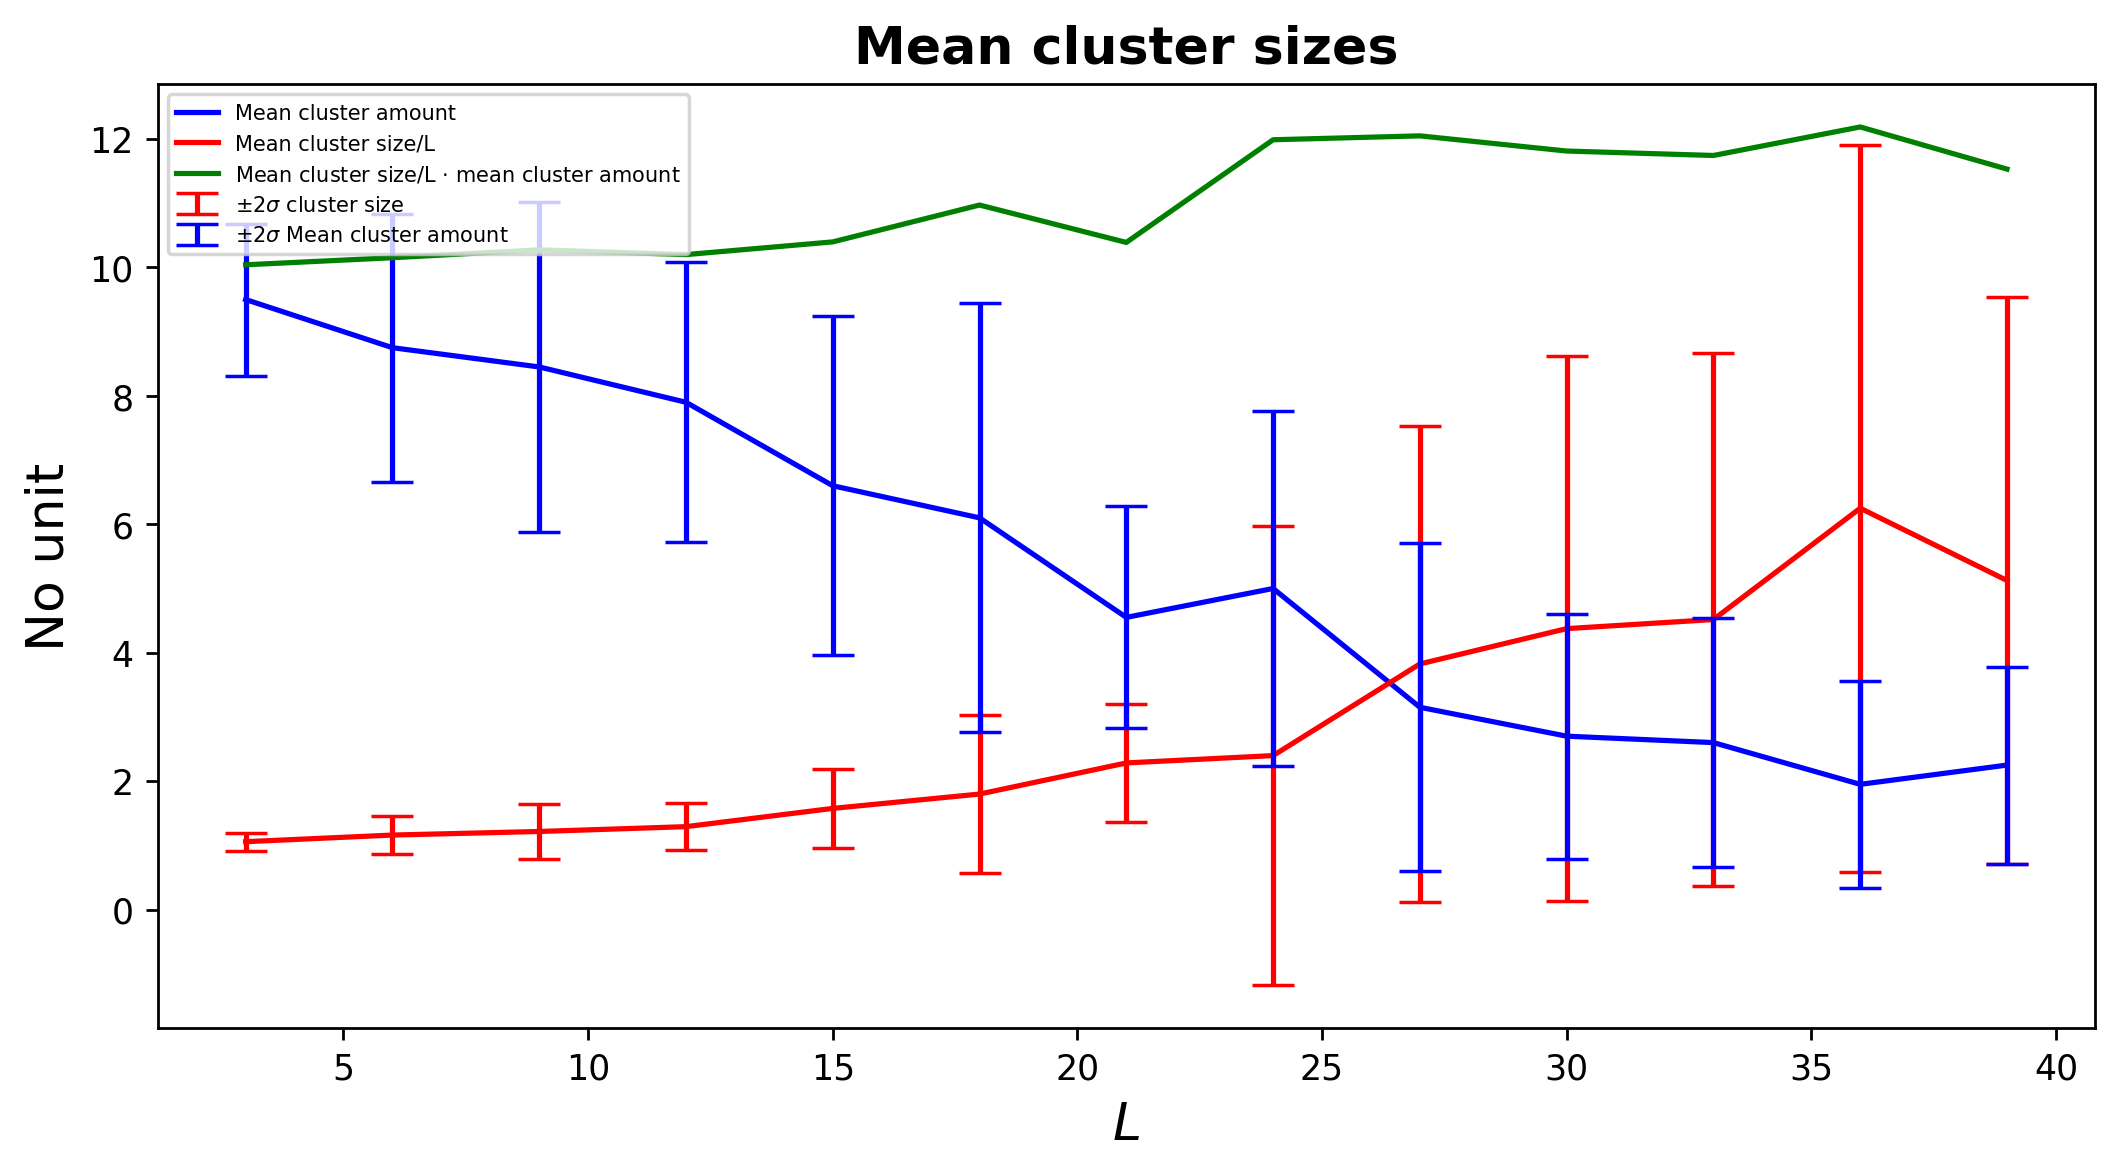

In [42]:
def plot_mean_cluster_sizes():
    # Unpack the relevant data  from the saved file
    L_l = 3
    L_h = 39
    number_of_lengths = 13
    lengths = np.linspace(L_l, L_h, number_of_lengths)
    
    simulation_data = np.load('mean_cluster_size_simulation.npz')
    mean_cluster_sizes = simulation_data['mean_cluster_sizes'] / lengths
    mean_stddev = simulation_data['mean_cluster_deviations'] /lengths
    cluster_amount_stddev = simulation_data['mean_number_of_clusters_deviations']
    mean_number_of_clusters = simulation_data['mean_number_of_clusters']
    
    plt.plot(lengths,mean_number_of_clusters, label="Mean cluster amount",color="blue")
    plt.plot(lengths,mean_cluster_sizes,label = "Mean cluster size/L",color = "red")

    # Plotting candlebars with 2 standard deviations
    plt.errorbar(lengths,mean_cluster_sizes,2*mean_stddev,capsize=6,linestyle="None",label="$\pm 2\sigma$ cluster size", color = "red")
    plt.errorbar(lengths,mean_number_of_clusters,2*cluster_amount_stddev,capsize=6,linestyle="None",color = "blue", label = "$\pm 2\sigma$ Mean cluster amount")
    plt.plot(lengths,mean_cluster_sizes*mean_number_of_clusters,color="green", label = "Mean cluster size/L $\cdot$ mean cluster amount ")
    
    plt.legend(loc=2, prop={'size': 6})
    # Add title and labelnames
    plt.title("Mean cluster sizes", size = 15, weight="bold") 
    plt.xlabel(r"$L$", size = 15)
    plt.ylabel(r"No unit", size = 15, rotation=90)
    
    # Showing the plot
    plt.show()  
plot_mean_cluster_sizes()


We notice that the $mean\ cluster\ size/L$ increases with increased values of $L$, which seems reasonable as larger values of $L$ increases the chance for two clusters to connect, so even when dividing by L afterwards, the value is expected to be larger. At the last datapoint, $L=39$, this trend reverses. We chalk that up to the large standard deviations, we would expect it to be higher if we ran the simulation again.
When it comes to mean cluster amount, it decreases with increasing $L$. This can be explained with similar reasoning: when $L$ increases, two given polymers are more likely to interact, and when they interact, they are considered one cluster instead of two. So the amount of clusters in the grid is reduced.

The mean cluster amount is actually inversely proportional to the mean cluster $size/L$. You can see this by considering the following:

- The amount of polymer on the grid is always equal to $2 M \cdot L$, as you have $2M$ amount of clusters, and they all have size $L$. 

- When you multiply the $\ mean\ amount\ of\  clusters/L \quad (=2M/L) \ $ by the $mean\ cluster\ size\ \ (L)$, the expected value would be $2M/L \cdot L = 2M$, so the same as above. 


With $M=5$ this is $10$. Which is reasonably close to the value of the plotted green line, considering the standard deviations. The line jumps up slightly at the end, but that can be explained by the fact that the variance of $L$ is largest at high values of $L$, so we expect the results to vary the most here.

With rigid move, one would expect the mean cluster size to be smaller, as they don’t interact as much. Using the same logic as previously, the mean amount of clusters would be larger.

If we were to for example increase the value of $M$, there would be more polymers in the grid. This would obviously result in an increase in the mean monomer amount. One would also expect a slight increase in the mean monomer size, as the grid is the same size so more monomers means that they will make slightly more contact with other polymers.


# 3.0 Conclusion

In this paper, we have utilized the Monte Carlo-algorithm to simulate the formation of membrane-less organelles in systems consisting of polymers - which again are composed out of oppositely charged monomers. 

We have shown that for lower temperatures, monomers more easily form into larger polymers than they do for higher temperature-values, but take a longer time to reach equilibrium. This is because of thermal fluctuations, where a higher temperature leads to a higher probability for random movements and fluctuations to occur. The higher temperature will also result in the monomers forming smaller clusters that they do for lower temperatures, as they more easily can reduce their energy by forming bonds to monomers with the opposite charge.

After observing that monomers cluster together to minimize energy, we introduced monomer connectivity. When monomers form covalent bonds, they act as a unit, called polymers. The aggregate formation of these clusters were then observed after running a Monte Carlo simulation. However, simply up-scaling the movement of single monomers did not yield viable results, as their ability to interact with each other was impaired. Hence we had introduced a new way of movement, which opened for flexible polymers that clustered together.

We were interested in the phenomena of clustering polymers, so we investigated how their size affected the clustering. We were specifically interested in the normalized mean cluster size and number of clusters. As we already had an effective way of simulating the biological systems of polymers, we did a number of simulations. Where we sampled and measured these quantities. An increasing polymer size resulted in a steady increase of the polymers normalized mean cluster size.


Overall this project has given an interesting insight into formation of biological structures, and ways to model them using numerical methods. It has been useful to experience the fact that the theories from electromagnetism have such an impact in the field of biology, and see a practical example of how these two disciplines can be used together to achieve a deeper understanding of our physical world.
